## Experiment Setup

### Random seed / PyTorch / CUDA related

In [1]:
import time
import datetime
import os
import sys
import itertools

# Use Google Colab
use_colab = True

# Is this notebook running on Colab?
# If so, then google.colab package (github.com/googlecolab/colabtools)
# should be available in this environment

# Previous version used importlib, but we could do the same thing with
# just attempting to import google.colab
try:
    from google.colab import drive
    colab_available = True
except:
    colab_available = False

if use_colab and colab_available:
    drive.mount('/content/drive')
    
    # If there's a package I need to install separately, do it here
    !pip install pyro-ppl

    # cd to the appropriate working directory under my Google Drive
    %cd 'drive/My Drive/Colab Notebooks/bayesian-dl-experiments'
    
    # List the directory contents
    !ls

# IPython reloading magic
%load_ext autoreload
%autoreload 2

# Random seeds
# Based on https://pytorch.org/docs/stable/notes/randomness.html
random_seed = 682

### Third party libraries (NumPy, PyTorch, Pyro)

In [2]:
# Third party libraries import
import numpy as np
import torch
import pyro
import matplotlib.pyplot as plt

# Print version information
print("Python Version: " + sys.version)
print("NumPy Version: " + np.__version__)
print("PyTorch Version: " + torch.__version__)
print("Pyro Version: " + pyro.__version__)

Python Version: 3.7.4 (default, Aug 13 2019, 15:17:50) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
NumPy Version: 1.17.2
PyTorch Version: 1.3.1
Pyro Version: 1.0.0


In [3]:
# More imports...
from torch import nn, optim
from torch.utils.data import random_split, DataLoader, RandomSampler
import torchvision
import torchvision.transforms as transforms
from pyro.infer import SVI, Trace_ELBO, HMC, MCMC

# Import model and dataset classes from ronald_bdl
from ronald_bdl import models, datasets

# pyplot setting
%matplotlib inline

# torch.device / CUDA Setup
use_cuda = True

if use_cuda and torch.cuda.is_available():
    torch_device = torch.device('cuda')

    torch.backends.cudnn.deterministic = True
    
    # Disable 'benchmark' mode
    # Note: https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936
    torch.backends.cudnn.benchmark = False
    use_pin_memory = True # Faster Host to GPU copies with page-locked memory

    # CUDA libraries version information
    print("CUDA Version: " + str(torch.version.cuda))
    print("cuDNN Version: " + str(torch.backends.cudnn.version()))
    print("CUDA Device Name: " + str(torch.cuda.get_device_name()))
    print("CUDA Capabilities: "+ str(torch.cuda.get_device_capability()))
else:
    torch_device = torch.device('cpu')
    use_pin_memory = False

### Variable settings

#### Data prep

In [4]:
# Dataset to use
uci_dataset_name = 'yacht'

# Set the proportion of the original dataset to be available as a whole
subset_proportions = [1]

# Proportion of the dataset to be used for training
dataset_train_size = 0.8

# Number of dataset splits
n_splits = 10

#### NN settings

In [5]:
# Fully-Connected network hidden layers
network_hidden_dims = [25, 50, 100]
network_hidden_layers = [1, 3, 5]

# Dropout
dropout_rates = [0.1, 0.3, 0.5, 0.7]

# Regularization strengths
reg_strengths = [0.05]


### Training setup

In [6]:
# Epochs
n_epochs = [10, 100, 1000]

# Optimizer learning rate
learning_rate = 0.01 # PyTorch default value is 0.001

# Training data batch sizes
if uci_dataset_name in ('protein-tertiary-structure'): # Note: 45730 rows originally
    n_training_batch = 128
elif uci_dataset_name in ('yacht', 'bostonHousing'):
    n_training_batch = 32

# Number of test predictions (for each data point)
n_prediction = 500

# Mean Squared Error for loss function to minimize
objective = nn.MSELoss()

# Test start time
test_start_time = datetime.datetime.today().strftime('%Y%m%d%H%M')

## Train the network

In [7]:
for subset_prop, hidden_dim, n_hidden, dropout_rate, reg_strength, n_epoch in itertools.product(
    subset_proportions,
    network_hidden_dims, network_hidden_layers,
    dropout_rates, reg_strengths,
    n_epochs,
):
    # Reset the random number generator for each method (to produce identical results)
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    pyro.set_rng_seed(random_seed)

    # Print parameter combinations being tested
    print(
        "subset %f, n_hidden %d, hidden_dim %d, dropout_rate %f, reg_strength %f"
        % (subset_prop, n_hidden, hidden_dim, dropout_rate, reg_strength))
    
    print("n_epoch %d" % n_epoch)
    print()

    """
    Results file storage
    """

    # Create directory to store results for the current test configuration
    test_results_path = os.path.join(
        './test_results',
        'error_convergence_1',
        uci_dataset_name,
        test_start_time,
        (
            str(subset_prop) 
            + '_' + str(hidden_dim) 
            + '_' + str(n_hidden) 
            + '_' + str(dropout_rate) 
            + '_' + str(reg_strength)
            + '_' + str(n_epoch)),
    )
    
    os.makedirs(test_results_path, exist_ok=True)
    
    test_results_rmse_mc_path = os.path.join(
        test_results_path,
        "rmse_mc.txt"
    )
    
    test_results_lls_mc_path = os.path.join(
        test_results_path,
        "lls_mc.txt"
    )

    test_results_rmse_non_mc_path = os.path.join(
        test_results_path,
        "rmse_non_mc.txt"
    )    

    """
    Dataset multiple splits prep
    """

    # Prepare new subset of the original dataset
    subset = datasets.UCIDatasets(
        uci_dataset_name, root_dir='./datasets_files', 
        limit_size=subset_prop, transform=None, download=True)

    # Determine sizes of training and testing set
    train_size = int(dataset_train_size * len(subset))
    test_size = len(subset) - train_size
    
    # Print the size of the subset
    print("subset size = " + str((len(subset), subset.n_features)))
    print("training set size = %d" % train_size)
    print("test set size = %d" % test_size)
    print()
    
    # Prepare multiple sets of random train-test splits 
    # to test the parameter combination
    subset_splits = []

    for _ in range(n_splits):
        train, test = random_split(subset, lengths=[train_size, test_size])
        subset_splits.append((train, test))

    # Try learning with different splits
    for s, (train, test) in enumerate(subset_splits):

        """
        Training
        """
      
        print('Training with split %d' % s)

        train_loader = DataLoader(train, batch_size=n_training_batch, pin_memory=use_pin_memory)

        # Prepare network
        network = models.FCNetMCDropout(
          input_dim=subset.n_features, 
          output_dim=subset.n_targets,
          hidden_dim=hidden_dim,
          n_hidden=n_hidden,
          dropout_rate=dropout_rate,
          dropout_type='bernoulli',
        )

        # Send the whole model to the selected torch.device
        network.to(torch_device)

        # Model to train mode
        network.train()

        # Adam optimizer
        # https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam
        # NOTE: Need to set L2 regularization from here
        optimizer = optim.Adam(
            network.parameters(),
            lr=learning_rate,
            weight_decay=reg_strength, # L2 regularization
        )

        # Record training start time (for this split)
        tic = time.time()

        for epoch in range(n_epoch): # loop over the dataset multiple times
            # Mini-batches
            for data in train_loader:
                # get the inputs; data is a list of [inputs, labels]
                inputs, targets = data

                # Store the batch to torch_device's memory
                inputs = inputs.to(torch_device)
                targets = targets.to(torch_device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = network(inputs)

                loss = objective(outputs, targets)
                loss.backward()

                optimizer.step()

        # Record training end time
        toc = time.time()

        # Report the final loss
        print("final loss = %f" % (loss.item()))

        """
        Testing
        """

        # Model to eval mode
        network.eval()

        # Get the test data
        inputs, targets = test.dataset[test.indices]

        # Store the batch to torch_device's memory
        inputs = inputs.to(torch_device)
        targets = targets.to(torch_device)

        # Record testing start time
        tic_testing = time.time()

        _, mean, var, metrics = network.predict_dist(
            inputs, n_prediction, y_test=targets, reg_strength=reg_strength)
        
        # Record testing end time
        toc_testing = time.time()

        # Record all the scores to the score files
        if len(metrics) > 0:
            for key, value in metrics.items():
                print(str(key) + " = " + str(value))

                if key == 'rmse_mc':
                    with open(test_results_rmse_mc_path, 'a+') as rmse_mc_file:
                        rmse_mc_file.write('%d %f \n' % (s, value))

                elif key == 'test_ll_mc':
                    with open(test_results_lls_mc_path, 'a+') as lls_mc_file:
                        lls_mc_file.write('%d %f \n' % (s, value))

                elif key == 'rmse_non_mc':
                    with open(test_results_rmse_non_mc_path, 'a+') as rmse_non_mc_file:
                        rmse_non_mc_file.write('%d %f \n' % (s, value))
                        
        # Report the total training time
        print("training time = " + str(toc - tic) + " seconds")

        # Report the total testing time
        print("testing time = " + str(toc_testing - tic_testing) + " seconds")

        print()

subset 1.000000, n_hidden 1, hidden_dim 25, dropout_rate 0.100000, reg_strength 0.050000
n_epoch 10

Using downloaded and verified file: ./datasets_files/yacht/yacht_hydrodynamics.data
subset size = (308, 6)
training set size = 246
test set size = 62

Training with split 0
final loss = 264.257111
rmse_mc = tensor(15.5799)
rmse_non_mc = tensor(15.6000)
test_ll_mc = tensor(-7.4583)
training time = 0.19559097290039062 seconds
testing time = 0.10612082481384277 seconds

Training with split 1
final loss = 373.705383
rmse_mc = tensor(13.0486)
rmse_non_mc = tensor(13.0498)
test_ll_mc = tensor(-5.8579)
training time = 0.16544818878173828 seconds
testing time = 0.10001587867736816 seconds

Training with split 2
final loss = 245.220398
rmse_mc = tensor(15.7652)
rmse_non_mc = tensor(15.7784)
test_ll_mc = tensor(-8.0524)
training time = 0.16138291358947754 seconds
testing time = 0.09470105171203613 seconds

Training with split 3
final loss = 277.254822
rmse_mc = tensor(14.9632)
rmse_non_mc = tenso

final loss = 147.866028
rmse_mc = tensor(17.1416)
rmse_non_mc = tensor(17.1333)
test_ll_mc = tensor(-7.0262)
training time = 0.16470813751220703 seconds
testing time = 0.08622288703918457 seconds

Training with split 5
final loss = 449.215637
rmse_mc = tensor(15.8287)
rmse_non_mc = tensor(15.8256)
test_ll_mc = tensor(-5.9980)
training time = 0.16272401809692383 seconds
testing time = 0.0858297348022461 seconds

Training with split 6
final loss = 381.228668
rmse_mc = tensor(18.3175)
rmse_non_mc = tensor(18.3119)
test_ll_mc = tensor(-8.5373)
training time = 0.16153287887573242 seconds
testing time = 0.08505487442016602 seconds

Training with split 7
final loss = 280.638916
rmse_mc = tensor(13.8636)
rmse_non_mc = tensor(13.8796)
test_ll_mc = tensor(-5.8549)
training time = 0.1609339714050293 seconds
testing time = 0.08396792411804199 seconds

Training with split 8
final loss = 396.095459
rmse_mc = tensor(15.9436)
rmse_non_mc = tensor(16.0141)
test_ll_mc = tensor(-6.5859)
training time = 0

final loss = 249.120270
rmse_mc = tensor(16.1997)
rmse_non_mc = tensor(16.2501)
test_ll_mc = tensor(-5.4458)
training time = 0.1604459285736084 seconds
testing time = 0.08721613883972168 seconds

subset 1.000000, n_hidden 1, hidden_dim 25, dropout_rate 0.500000, reg_strength 0.050000
n_epoch 100

Using downloaded and verified file: ./datasets_files/yacht/yacht_hydrodynamics.data
subset size = (308, 6)
training set size = 246
test set size = 62

Training with split 0
final loss = 303.186920
rmse_mc = tensor(13.4936)
rmse_non_mc = tensor(13.6275)
test_ll_mc = tensor(-3.4246)
training time = 1.5824668407440186 seconds
testing time = 0.07634878158569336 seconds

Training with split 1
final loss = 424.637390
rmse_mc = tensor(11.1256)
rmse_non_mc = tensor(11.0807)
test_ll_mc = tensor(-3.2759)
training time = 1.6687507629394531 seconds
testing time = 0.08901596069335938 seconds

Training with split 2
final loss = 293.947357
rmse_mc = tensor(12.7822)
rmse_non_mc = tensor(12.7953)
test_ll_mc = 

final loss = 298.154144
rmse_mc = tensor(16.6133)
rmse_non_mc = tensor(16.5941)
test_ll_mc = tensor(-4.2385)
training time = 1.7300519943237305 seconds
testing time = 0.09173774719238281 seconds

Training with split 3
final loss = 223.774689
rmse_mc = tensor(17.1739)
rmse_non_mc = tensor(17.1744)
test_ll_mc = tensor(-6.1102)
training time = 1.6625750064849854 seconds
testing time = 0.0882260799407959 seconds

Training with split 4
final loss = 222.929291
rmse_mc = tensor(19.1267)
rmse_non_mc = tensor(19.0926)
test_ll_mc = tensor(-8.5862)
training time = 1.595832109451294 seconds
testing time = 0.08383727073669434 seconds

Training with split 5
final loss = 579.455688
rmse_mc = tensor(16.8295)
rmse_non_mc = tensor(16.8068)
test_ll_mc = tensor(-4.7302)
training time = 1.6426959037780762 seconds
testing time = 0.0851888656616211 seconds

Training with split 6
final loss = 464.478638
rmse_mc = tensor(19.7799)
rmse_non_mc = tensor(19.7936)
test_ll_mc = tensor(-8.4688)
training time = 1.5967

final loss = 27.217615
rmse_mc = tensor(5.3333)
rmse_non_mc = tensor(5.2655)
test_ll_mc = tensor(-2.7883)
training time = 1.9128801822662354 seconds
testing time = 0.14748406410217285 seconds

Training with split 8
final loss = 79.177681
rmse_mc = tensor(5.0417)
rmse_non_mc = tensor(5.0728)
test_ll_mc = tensor(-3.1378)
training time = 1.901719093322754 seconds
testing time = 0.14180207252502441 seconds

Training with split 9
final loss = 46.014458
rmse_mc = tensor(4.5118)
rmse_non_mc = tensor(4.6226)
test_ll_mc = tensor(-2.6912)
training time = 2.0516390800476074 seconds
testing time = 0.15090489387512207 seconds

subset 1.000000, n_hidden 3, hidden_dim 25, dropout_rate 0.100000, reg_strength 0.050000
n_epoch 1000

Using downloaded and verified file: ./datasets_files/yacht/yacht_hydrodynamics.data
subset size = (308, 6)
training set size = 246
test set size = 62

Training with split 0
final loss = 11.914302
rmse_mc = tensor(6.0889)
rmse_non_mc = tensor(5.9753)
test_ll_mc = tensor(-2.85

final loss = 273.319061
rmse_mc = tensor(9.9577)
rmse_non_mc = tensor(9.5360)
test_ll_mc = tensor(-3.8807)
training time = 19.708881855010986 seconds
testing time = 0.16599512100219727 seconds

Training with split 2
final loss = 309.421661
rmse_mc = tensor(8.8206)
rmse_non_mc = tensor(10.4476)
test_ll_mc = tensor(-3.1714)
training time = 20.11223077774048 seconds
testing time = 0.18604326248168945 seconds

Training with split 3
final loss = 245.697403
rmse_mc = tensor(15.5821)
rmse_non_mc = tensor(15.5724)
test_ll_mc = tensor(-7.4184)
training time = 20.435750007629395 seconds
testing time = 0.1545569896697998 seconds

Training with split 4
final loss = 168.933304
rmse_mc = tensor(9.4509)
rmse_non_mc = tensor(12.0693)
test_ll_mc = tensor(-3.1834)
training time = 20.562807083129883 seconds
testing time = 0.17653417587280273 seconds

Training with split 5
final loss = 383.977600
rmse_mc = tensor(9.1197)
rmse_non_mc = tensor(11.3055)
test_ll_mc = tensor(-3.0996)
training time = 20.4915471

final loss = 453.016663
rmse_mc = tensor(18.7514)
rmse_non_mc = tensor(18.7682)
test_ll_mc = tensor(-9.3051)
training time = 20.358901023864746 seconds
testing time = 0.20817995071411133 seconds

Training with split 7
final loss = 268.160950
rmse_mc = tensor(14.1387)
rmse_non_mc = tensor(14.1270)
test_ll_mc = tensor(-6.0594)
training time = 20.70093822479248 seconds
testing time = 0.2178208827972412 seconds

Training with split 8
final loss = 287.309875
rmse_mc = tensor(16.5481)
rmse_non_mc = tensor(16.5509)
test_ll_mc = tensor(-7.6632)
training time = 20.040340185165405 seconds
testing time = 0.16942119598388672 seconds

Training with split 9
final loss = 259.950500
rmse_mc = tensor(16.0056)
rmse_non_mc = tensor(16.0060)
test_ll_mc = tensor(-7.4598)
training time = 20.295849084854126 seconds
testing time = 0.20250701904296875 seconds

subset 1.000000, n_hidden 3, hidden_dim 25, dropout_rate 0.700000, reg_strength 0.050000
n_epoch 10

Using downloaded and verified file: ./datasets_file

Training with split 0
final loss = 280.946808
rmse_mc = tensor(15.6006)
rmse_non_mc = tensor(15.5830)
test_ll_mc = tensor(-6.6073)
training time = 0.23139286041259766 seconds
testing time = 0.18831825256347656 seconds

Training with split 1
final loss = 307.252777
rmse_mc = tensor(13.2536)
rmse_non_mc = tensor(13.2251)
test_ll_mc = tensor(-5.1626)
training time = 0.23804402351379395 seconds
testing time = 0.2371232509613037 seconds

Training with split 2
final loss = 289.493286
rmse_mc = tensor(15.6075)
rmse_non_mc = tensor(15.6177)
test_ll_mc = tensor(-7.3451)
training time = 0.22956490516662598 seconds
testing time = 0.21319913864135742 seconds

Training with split 3
final loss = 163.391068
rmse_mc = tensor(14.9046)
rmse_non_mc = tensor(14.9006)
test_ll_mc = tensor(-6.5349)
training time = 0.23057889938354492 seconds
testing time = 0.22329401969909668 seconds

Training with split 4
final loss = 145.677765
rmse_mc = tensor(15.5772)
rmse_non_mc = tensor(15.6061)
test_ll_mc = tensor(-6.

final loss = 413.679260
rmse_mc = tensor(15.7497)
rmse_non_mc = tensor(15.8231)
test_ll_mc = tensor(-4.1478)
training time = 0.2332899570465088 seconds
testing time = 0.2431778907775879 seconds

Training with split 6
final loss = 407.241974
rmse_mc = tensor(18.0368)
rmse_non_mc = tensor(18.1260)
test_ll_mc = tensor(-5.8821)
training time = 0.23098325729370117 seconds
testing time = 0.20520591735839844 seconds

Training with split 7
final loss = 302.736633
rmse_mc = tensor(13.4812)
rmse_non_mc = tensor(13.5608)
test_ll_mc = tensor(-4.4370)
training time = 0.22695231437683105 seconds
testing time = 0.21255135536193848 seconds

Training with split 8
final loss = 365.948792
rmse_mc = tensor(16.4342)
rmse_non_mc = tensor(16.4944)
test_ll_mc = tensor(-6.5029)
training time = 0.22792887687683105 seconds
testing time = 0.20847177505493164 seconds

Training with split 9
final loss = 250.055740
rmse_mc = tensor(15.6543)
rmse_non_mc = tensor(15.7416)
test_ll_mc = tensor(-5.2656)
training time = 0

final loss = 344.028625
rmse_mc = tensor(17.1715)
rmse_non_mc = tensor(17.1652)
test_ll_mc = tensor(-7.2041)
training time = 2.2680070400238037 seconds
testing time = 0.19800376892089844 seconds

Training with split 1
final loss = 497.238953
rmse_mc = tensor(13.4129)
rmse_non_mc = tensor(13.4484)
test_ll_mc = tensor(-5.1775)
training time = 2.2675840854644775 seconds
testing time = 0.22524213790893555 seconds

Training with split 2
final loss = 400.048157
rmse_mc = tensor(16.1054)
rmse_non_mc = tensor(16.1769)
test_ll_mc = tensor(-6.7509)
training time = 2.4073212146759033 seconds
testing time = 0.22007083892822266 seconds

Training with split 3
final loss = 357.101410
rmse_mc = tensor(15.9608)
rmse_non_mc = tensor(15.9815)
test_ll_mc = tensor(-6.2786)
training time = 2.3028337955474854 seconds
testing time = 0.2207012176513672 seconds

Training with split 4
final loss = 235.278610
rmse_mc = tensor(17.7360)
rmse_non_mc = tensor(17.7493)
test_ll_mc = tensor(-7.0423)
training time = 2.34

final loss = 609.609741
rmse_mc = tensor(17.0895)
rmse_non_mc = tensor(17.0516)
test_ll_mc = tensor(-6.7311)
training time = 2.22648286819458 seconds
testing time = 0.2061917781829834 seconds

Training with split 6
final loss = 488.573822
rmse_mc = tensor(19.8637)
rmse_non_mc = tensor(19.8774)
test_ll_mc = tensor(-9.0976)
training time = 2.2359402179718018 seconds
testing time = 0.20789813995361328 seconds

Training with split 7
final loss = 280.735992
rmse_mc = tensor(15.1584)
rmse_non_mc = tensor(15.2114)
test_ll_mc = tensor(-5.9606)
training time = 2.2663869857788086 seconds
testing time = 0.20637011528015137 seconds

Training with split 8
final loss = 378.846588
rmse_mc = tensor(17.4736)
rmse_non_mc = tensor(17.4770)
test_ll_mc = tensor(-6.9192)
training time = 2.2380709648132324 seconds
testing time = 0.20840978622436523 seconds

Training with split 9
final loss = 221.548904
rmse_mc = tensor(16.9307)
rmse_non_mc = tensor(16.9032)
test_ll_mc = tensor(-7.1052)
training time = 2.2834

final loss = 6.910707
rmse_mc = tensor(3.5359)
rmse_non_mc = tensor(3.6180)
test_ll_mc = tensor(-2.6064)
training time = 17.750917196273804 seconds
testing time = 0.12600207328796387 seconds

Training with split 1
final loss = 16.028114
rmse_mc = tensor(1.2797)
rmse_non_mc = tensor(1.2257)
test_ll_mc = tensor(-2.5874)
training time = 17.78351092338562 seconds
testing time = 0.11529803276062012 seconds

Training with split 2
final loss = 126.801224
rmse_mc = tensor(3.2939)
rmse_non_mc = tensor(3.4600)
test_ll_mc = tensor(-2.5704)
training time = 17.93579602241516 seconds
testing time = 0.11053800582885742 seconds

Training with split 3
final loss = 28.016933
rmse_mc = tensor(2.3646)
rmse_non_mc = tensor(2.3759)
test_ll_mc = tensor(-2.7382)
training time = 17.363702058792114 seconds
testing time = 0.12038397789001465 seconds

Training with split 4
final loss = 3.979440
rmse_mc = tensor(1.7102)
rmse_non_mc = tensor(1.7013)
test_ll_mc = tensor(-2.6562)
training time = 17.56637477874756 sec

final loss = 327.955139
rmse_mc = tensor(8.2563)
rmse_non_mc = tensor(8.1535)
test_ll_mc = tensor(-2.8512)
training time = 17.232052087783813 seconds
testing time = 0.11660313606262207 seconds

Training with split 6
final loss = 419.571228
rmse_mc = tensor(9.6256)
rmse_non_mc = tensor(9.1059)
test_ll_mc = tensor(-2.9642)
training time = 17.340866088867188 seconds
testing time = 0.12242794036865234 seconds

Training with split 7
final loss = 104.763336
rmse_mc = tensor(6.0461)
rmse_non_mc = tensor(5.0544)
test_ll_mc = tensor(-2.8903)
training time = 17.220849990844727 seconds
testing time = 0.11620092391967773 seconds

Training with split 8
final loss = 51.736206
rmse_mc = tensor(7.6234)
rmse_non_mc = tensor(7.7443)
test_ll_mc = tensor(-2.8558)
training time = 17.193063020706177 seconds
testing time = 0.11117911338806152 seconds

Training with split 9
final loss = 116.024734
rmse_mc = tensor(9.1903)
rmse_non_mc = tensor(9.3683)
test_ll_mc = tensor(-2.9076)
training time = 17.50607609748

final loss = 369.527435
rmse_mc = tensor(18.4215)
rmse_non_mc = tensor(18.7858)
test_ll_mc = tensor(-5.4595)
training time = 0.16969799995422363 seconds
testing time = 0.08694887161254883 seconds

Training with split 1
final loss = 482.196014
rmse_mc = tensor(14.7197)
rmse_non_mc = tensor(14.8687)
test_ll_mc = tensor(-4.7033)
training time = 0.16805505752563477 seconds
testing time = 0.0927581787109375 seconds

Training with split 2
final loss = 319.380554
rmse_mc = tensor(16.9694)
rmse_non_mc = tensor(17.2334)
test_ll_mc = tensor(-4.6232)
training time = 0.16992902755737305 seconds
testing time = 0.09285306930541992 seconds

Training with split 3
final loss = 284.869812
rmse_mc = tensor(17.8758)
rmse_non_mc = tensor(17.9769)
test_ll_mc = tensor(-6.2065)
training time = 0.16710996627807617 seconds
testing time = 0.09226131439208984 seconds

Training with split 4
final loss = 230.418915
rmse_mc = tensor(19.4554)
rmse_non_mc = tensor(19.9723)
test_ll_mc = tensor(-6.3287)
training time = 

final loss = 431.112152
rmse_mc = tensor(15.8751)
rmse_non_mc = tensor(15.8384)
test_ll_mc = tensor(-7.4958)
training time = 0.20589685440063477 seconds
testing time = 0.175034761428833 seconds

Training with split 6
final loss = 327.243286
rmse_mc = tensor(16.4539)
rmse_non_mc = tensor(16.4510)
test_ll_mc = tensor(-7.4878)
training time = 0.20163297653198242 seconds
testing time = 0.17032599449157715 seconds

Training with split 7
final loss = 245.470306
rmse_mc = tensor(12.5538)
rmse_non_mc = tensor(12.5755)
test_ll_mc = tensor(-5.2397)
training time = 0.2043442726135254 seconds
testing time = 0.16355586051940918 seconds

Training with split 8
final loss = 264.195526
rmse_mc = tensor(15.2330)
rmse_non_mc = tensor(15.2390)
test_ll_mc = tensor(-6.8859)
training time = 0.20195674896240234 seconds
testing time = 0.16849613189697266 seconds

Training with split 9
final loss = 219.557404
rmse_mc = tensor(15.5606)
rmse_non_mc = tensor(15.6260)
test_ll_mc = tensor(-6.7670)
training time = 0.

Training with split 0
final loss = 199.128601
rmse_mc = tensor(13.0154)
rmse_non_mc = tensor(14.4068)
test_ll_mc = tensor(-3.8373)
training time = 1.9983880519866943 seconds
testing time = 0.15501117706298828 seconds

Training with split 1
final loss = 223.189713
rmse_mc = tensor(5.9200)
rmse_non_mc = tensor(6.0373)
test_ll_mc = tensor(-3.1813)
training time = 2.002264976501465 seconds
testing time = 0.20189690589904785 seconds

Training with split 2
final loss = 284.773621
rmse_mc = tensor(9.0016)
rmse_non_mc = tensor(8.9550)
test_ll_mc = tensor(-3.1028)
training time = 2.013713836669922 seconds
testing time = 0.1745290756225586 seconds

Training with split 3
final loss = 160.321701
rmse_mc = tensor(11.8848)
rmse_non_mc = tensor(12.0479)
test_ll_mc = tensor(-3.3016)
training time = 1.9891042709350586 seconds
testing time = 0.1734158992767334 seconds

Training with split 4
final loss = 185.695587
rmse_mc = tensor(13.1786)
rmse_non_mc = tensor(13.0010)
test_ll_mc = tensor(-3.6595)
train

final loss = 603.212097
rmse_mc = tensor(16.4263)
rmse_non_mc = tensor(16.4388)
test_ll_mc = tensor(-7.1573)
training time = 1.9762248992919922 seconds
testing time = 0.1749742031097412 seconds

Training with split 6
final loss = 369.514343
rmse_mc = tensor(18.8356)
rmse_non_mc = tensor(18.8238)
test_ll_mc = tensor(-8.6960)
training time = 1.9844682216644287 seconds
testing time = 0.16953611373901367 seconds

Training with split 7
final loss = 254.184647
rmse_mc = tensor(14.1494)
rmse_non_mc = tensor(14.1722)
test_ll_mc = tensor(-5.6818)
training time = 1.9739761352539062 seconds
testing time = 0.1640031337738037 seconds

Training with split 8
final loss = 256.125244
rmse_mc = tensor(16.2805)
rmse_non_mc = tensor(16.2875)
test_ll_mc = tensor(-6.5460)
training time = 1.986994981765747 seconds
testing time = 0.16970491409301758 seconds

Training with split 9
final loss = 266.765076
rmse_mc = tensor(16.5080)
rmse_non_mc = tensor(16.5310)
test_ll_mc = tensor(-7.9168)
training time = 1.9808

final loss = 240.446152
rmse_mc = tensor(17.9866)
rmse_non_mc = tensor(18.0370)
test_ll_mc = tensor(-7.7858)
training time = 21.44438624382019 seconds
testing time = 0.20753002166748047 seconds

Training with split 1
final loss = 600.831848
rmse_mc = tensor(14.1887)
rmse_non_mc = tensor(14.2010)
test_ll_mc = tensor(-5.7385)
training time = 21.5883629322052 seconds
testing time = 0.2436079978942871 seconds

Training with split 2
final loss = 429.817169
rmse_mc = tensor(16.9371)
rmse_non_mc = tensor(16.8934)
test_ll_mc = tensor(-7.3478)
training time = 21.243704080581665 seconds
testing time = 0.24045801162719727 seconds

Training with split 3
final loss = 294.937927
rmse_mc = tensor(17.1102)
rmse_non_mc = tensor(17.0872)
test_ll_mc = tensor(-7.2368)
training time = 21.460175037384033 seconds
testing time = 0.22460198402404785 seconds

Training with split 4
final loss = 247.274368
rmse_mc = tensor(18.9388)
rmse_non_mc = tensor(18.9147)
test_ll_mc = tensor(-8.5501)
training time = 21.2281

final loss = 101.624718
rmse_mc = tensor(3.7248)
rmse_non_mc = tensor(3.5409)
test_ll_mc = tensor(-2.6825)
training time = 27.086018085479736 seconds
testing time = 0.29116201400756836 seconds

Training with split 6
final loss = 66.396164
rmse_mc = tensor(5.4902)
rmse_non_mc = tensor(6.3893)
test_ll_mc = tensor(-2.8182)
training time = 28.528606176376343 seconds
testing time = 0.3835620880126953 seconds

Training with split 7
final loss = 22.709927
rmse_mc = tensor(4.3191)
rmse_non_mc = tensor(5.2264)
test_ll_mc = tensor(-2.7644)
training time = 26.967309951782227 seconds
testing time = 0.2683897018432617 seconds

Training with split 8
final loss = 169.312775
rmse_mc = tensor(3.7648)
rmse_non_mc = tensor(6.3183)
test_ll_mc = tensor(-2.7819)
training time = 26.95839285850525 seconds
testing time = 0.28065919876098633 seconds

Training with split 9
final loss = 118.808945
rmse_mc = tensor(4.7656)
rmse_non_mc = tensor(4.5097)
test_ll_mc = tensor(-2.9124)
training time = 26.77978205680847 

final loss = 346.963409
rmse_mc = tensor(17.8386)
rmse_non_mc = tensor(17.9674)
test_ll_mc = tensor(-6.5162)
training time = 0.23798394203186035 seconds
testing time = 0.22572803497314453 seconds

Training with split 1
final loss = 442.667511
rmse_mc = tensor(13.8092)
rmse_non_mc = tensor(13.9067)
test_ll_mc = tensor(-4.3080)
training time = 0.23790907859802246 seconds
testing time = 0.28613805770874023 seconds

Training with split 2
final loss = 316.406250
rmse_mc = tensor(15.7754)
rmse_non_mc = tensor(15.8951)
test_ll_mc = tensor(-3.9178)
training time = 0.23871827125549316 seconds
testing time = 0.2523500919342041 seconds

Training with split 3
final loss = 241.471527
rmse_mc = tensor(16.7608)
rmse_non_mc = tensor(16.9928)
test_ll_mc = tensor(-5.2744)
training time = 0.24070072174072266 seconds
testing time = 0.2489778995513916 seconds

Training with split 4
final loss = 207.521515
rmse_mc = tensor(17.4457)
rmse_non_mc = tensor(17.7809)
test_ll_mc = tensor(-4.6419)
training time = 0

final loss = 602.624390
rmse_mc = tensor(17.4699)
rmse_non_mc = tensor(17.7887)
test_ll_mc = tensor(-4.0046)
training time = 0.2382068634033203 seconds
testing time = 0.23890042304992676 seconds

Training with split 6
final loss = 535.351501
rmse_mc = tensor(20.3419)
rmse_non_mc = tensor(20.5980)
test_ll_mc = tensor(-5.3818)
training time = 0.23709416389465332 seconds
testing time = 0.25196385383605957 seconds

Training with split 7
final loss = 249.184814
rmse_mc = tensor(15.6536)
rmse_non_mc = tensor(15.9220)
test_ll_mc = tensor(-4.2507)
training time = 0.2388780117034912 seconds
testing time = 0.24546194076538086 seconds

Training with split 8
final loss = 434.088562
rmse_mc = tensor(17.8094)
rmse_non_mc = tensor(18.1330)
test_ll_mc = tensor(-4.3979)
training time = 0.23481011390686035 seconds
testing time = 0.25394296646118164 seconds

Training with split 9
final loss = 297.350037
rmse_mc = tensor(17.3050)
rmse_non_mc = tensor(17.5835)
test_ll_mc = tensor(-4.2609)
training time = 0

final loss = 19.660198
rmse_mc = tensor(3.6075)
rmse_non_mc = tensor(3.6514)
test_ll_mc = tensor(-2.6664)
training time = 1.7740652561187744 seconds
testing time = 0.10767602920532227 seconds

Training with split 1
final loss = 37.843090
rmse_mc = tensor(2.6935)
rmse_non_mc = tensor(2.6670)
test_ll_mc = tensor(-2.6312)
training time = 1.767359972000122 seconds
testing time = 0.13283085823059082 seconds

Training with split 2
final loss = 152.607803
rmse_mc = tensor(7.6915)
rmse_non_mc = tensor(7.7060)
test_ll_mc = tensor(-3.2773)
training time = 1.7621128559112549 seconds
testing time = 0.12814617156982422 seconds

Training with split 3
final loss = 84.544350
rmse_mc = tensor(3.9550)
rmse_non_mc = tensor(3.7454)
test_ll_mc = tensor(-2.9020)
training time = 1.7593090534210205 seconds
testing time = 0.12059807777404785 seconds

Training with split 4
final loss = 138.820969
rmse_mc = tensor(4.1543)
rmse_non_mc = tensor(4.1118)
test_ll_mc = tensor(-2.7088)
training time = 1.754152059555053

final loss = 177.217178
rmse_mc = tensor(7.3122)
rmse_non_mc = tensor(7.3840)
test_ll_mc = tensor(-2.8259)
training time = 1.7829020023345947 seconds
testing time = 0.11818432807922363 seconds

Training with split 6
final loss = 224.230545
rmse_mc = tensor(7.6893)
rmse_non_mc = tensor(7.6125)
test_ll_mc = tensor(-3.1863)
training time = 1.7826080322265625 seconds
testing time = 0.12192797660827637 seconds

Training with split 7
final loss = 27.977604
rmse_mc = tensor(4.9862)
rmse_non_mc = tensor(4.9686)
test_ll_mc = tensor(-3.1909)
training time = 1.7751429080963135 seconds
testing time = 0.12396073341369629 seconds

Training with split 8
final loss = 96.553635
rmse_mc = tensor(9.8865)
rmse_non_mc = tensor(9.9667)
test_ll_mc = tensor(-3.0649)
training time = 1.7701067924499512 seconds
testing time = 0.11672282218933105 seconds

Training with split 9
final loss = 181.628052
rmse_mc = tensor(11.3359)
rmse_non_mc = tensor(11.3691)
test_ll_mc = tensor(-3.4123)
training time = 1.78309822082

final loss = 377.168915
rmse_mc = tensor(14.2796)
rmse_non_mc = tensor(15.6309)
test_ll_mc = tensor(-3.3189)
training time = 20.33388376235962 seconds
testing time = 0.16480684280395508 seconds

Training with split 1
final loss = 495.965485
rmse_mc = tensor(10.5258)
rmse_non_mc = tensor(10.8438)
test_ll_mc = tensor(-3.1100)
training time = 20.230496168136597 seconds
testing time = 0.18933987617492676 seconds

Training with split 2
final loss = 391.923065
rmse_mc = tensor(13.1613)
rmse_non_mc = tensor(14.3716)
test_ll_mc = tensor(-3.2721)
training time = 20.18832302093506 seconds
testing time = 0.1889951229095459 seconds

Training with split 3
final loss = 210.169037
rmse_mc = tensor(13.2798)
rmse_non_mc = tensor(13.6831)
test_ll_mc = tensor(-3.2181)
training time = 20.123225927352905 seconds
testing time = 0.17234301567077637 seconds

Training with split 4
final loss = 178.202454
rmse_mc = tensor(16.6870)
rmse_non_mc = tensor(16.5788)
test_ll_mc = tensor(-6.5250)
training time = 20.119

final loss = 613.122986
rmse_mc = tensor(17.0107)
rmse_non_mc = tensor(17.0139)
test_ll_mc = tensor(-7.5225)
training time = 19.875086069107056 seconds
testing time = 0.17131495475769043 seconds

Training with split 6
final loss = 479.689850
rmse_mc = tensor(19.7297)
rmse_non_mc = tensor(19.6604)
test_ll_mc = tensor(-9.2744)
training time = 19.892509937286377 seconds
testing time = 0.1774148941040039 seconds

Training with split 7
final loss = 323.716858
rmse_mc = tensor(15.0222)
rmse_non_mc = tensor(15.0100)
test_ll_mc = tensor(-6.0759)
training time = 19.846248865127563 seconds
testing time = 0.1786642074584961 seconds

Training with split 8
final loss = 361.393097
rmse_mc = tensor(17.4008)
rmse_non_mc = tensor(17.4230)
test_ll_mc = tensor(-7.7101)
training time = 19.769102096557617 seconds
testing time = 0.1631910800933838 seconds

Training with split 9
final loss = 164.399261
rmse_mc = tensor(16.7416)
rmse_non_mc = tensor(16.7278)
test_ll_mc = tensor(-7.3892)
training time = 19.887

final loss = 342.583282
rmse_mc = tensor(16.5258)
rmse_non_mc = tensor(16.5429)
test_ll_mc = tensor(-6.3201)
training time = 0.2338569164276123 seconds
testing time = 0.23039579391479492 seconds

Training with split 1
final loss = 418.305695
rmse_mc = tensor(13.4421)
rmse_non_mc = tensor(13.4406)
test_ll_mc = tensor(-5.4496)
training time = 0.2392442226409912 seconds
testing time = 0.27780580520629883 seconds

Training with split 2
final loss = 391.555908
rmse_mc = tensor(16.4427)
rmse_non_mc = tensor(16.4619)
test_ll_mc = tensor(-7.1987)
training time = 0.23754501342773438 seconds
testing time = 0.2518620491027832 seconds

Training with split 3
final loss = 189.418900
rmse_mc = tensor(14.6853)
rmse_non_mc = tensor(14.7337)
test_ll_mc = tensor(-4.8814)
training time = 0.23663902282714844 seconds
testing time = 0.253587007522583 seconds

Training with split 4
final loss = 248.572906
rmse_mc = tensor(16.0795)
rmse_non_mc = tensor(16.0982)
test_ll_mc = tensor(-5.0811)
training time = 0.23

final loss = 582.275146
rmse_mc = tensor(15.9134)
rmse_non_mc = tensor(16.0750)
test_ll_mc = tensor(-4.0619)
training time = 0.23695778846740723 seconds
testing time = 0.2305159568786621 seconds

Training with split 6
final loss = 475.880524
rmse_mc = tensor(19.2164)
rmse_non_mc = tensor(19.3278)
test_ll_mc = tensor(-5.8059)
training time = 0.23442578315734863 seconds
testing time = 0.22864294052124023 seconds

Training with split 7
final loss = 105.108482
rmse_mc = tensor(13.5373)
rmse_non_mc = tensor(13.6281)
test_ll_mc = tensor(-3.7948)
training time = 0.23043203353881836 seconds
testing time = 0.22364091873168945 seconds

Training with split 8
final loss = 359.658966
rmse_mc = tensor(16.6417)
rmse_non_mc = tensor(16.7091)
test_ll_mc = tensor(-4.5849)
training time = 0.22906780242919922 seconds
testing time = 0.226729154586792 seconds

Training with split 9
final loss = 250.246658
rmse_mc = tensor(16.1148)
rmse_non_mc = tensor(16.2202)
test_ll_mc = tensor(-4.9794)
training time = 0.

final loss = 412.690796
rmse_mc = tensor(18.0223)
rmse_non_mc = tensor(18.0460)
test_ll_mc = tensor(-6.8680)
training time = 2.330411195755005 seconds
testing time = 0.21956777572631836 seconds

Training with split 1
final loss = 588.709106
rmse_mc = tensor(14.2401)
rmse_non_mc = tensor(14.2934)
test_ll_mc = tensor(-5.3606)
training time = 2.3349921703338623 seconds
testing time = 0.28407883644104004 seconds

Training with split 2
final loss = 453.449158
rmse_mc = tensor(16.9874)
rmse_non_mc = tensor(16.9894)
test_ll_mc = tensor(-6.9861)
training time = 2.33052396774292 seconds
testing time = 0.2430858612060547 seconds

Training with split 3
final loss = 258.230408
rmse_mc = tensor(17.2184)
rmse_non_mc = tensor(17.2378)
test_ll_mc = tensor(-7.0481)
training time = 2.330662250518799 seconds
testing time = 0.2577381134033203 seconds

Training with split 4
final loss = 189.083618
rmse_mc = tensor(19.0528)
rmse_non_mc = tensor(19.0644)
test_ll_mc = tensor(-8.0163)
training time = 2.3145148

final loss = 68.279686
rmse_mc = tensor(3.5986)
rmse_non_mc = tensor(3.5784)
test_ll_mc = tensor(-2.7083)
training time = 2.8750240802764893 seconds
testing time = 0.35370492935180664 seconds

Training with split 6
final loss = 19.584902
rmse_mc = tensor(4.0085)
rmse_non_mc = tensor(3.9039)
test_ll_mc = tensor(-2.8615)
training time = 2.8686461448669434 seconds
testing time = 0.3305327892303467 seconds

Training with split 7
final loss = 15.268251
rmse_mc = tensor(3.2399)
rmse_non_mc = tensor(3.2904)
test_ll_mc = tensor(-2.8506)
training time = 2.8622429370880127 seconds
testing time = 0.3338038921356201 seconds

Training with split 8
final loss = 267.510681
rmse_mc = tensor(4.2765)
rmse_non_mc = tensor(4.2915)
test_ll_mc = tensor(-2.9267)
training time = 2.854877233505249 seconds
testing time = 0.3359649181365967 seconds

Training with split 9
final loss = 17.449732
rmse_mc = tensor(5.6803)
rmse_non_mc = tensor(5.5388)
test_ll_mc = tensor(-3.1057)
training time = 2.8580048084259033 se

final loss = 234.943985
rmse_mc = tensor(12.8698)
rmse_non_mc = tensor(12.3969)
test_ll_mc = tensor(-4.7040)
training time = 38.484503984451294 seconds
testing time = 0.45619988441467285 seconds

Training with split 1
final loss = 433.373260
rmse_mc = tensor(9.9087)
rmse_non_mc = tensor(9.1758)
test_ll_mc = tensor(-3.9119)
training time = 38.37891364097595 seconds
testing time = 0.5108747482299805 seconds

Training with split 2
final loss = 315.378143
rmse_mc = tensor(10.5277)
rmse_non_mc = tensor(10.6420)
test_ll_mc = tensor(-3.7999)
training time = 38.306922912597656 seconds
testing time = 0.46997690200805664 seconds

Training with split 3
final loss = 222.856400
rmse_mc = tensor(12.6065)
rmse_non_mc = tensor(12.4321)
test_ll_mc = tensor(-5.0190)
training time = 38.57102727890015 seconds
testing time = 0.47724127769470215 seconds

Training with split 4
final loss = 203.336304
rmse_mc = tensor(17.0832)
rmse_non_mc = tensor(17.0540)
test_ll_mc = tensor(-8.3727)
training time = 39.20829

final loss = 475.631592
rmse_mc = tensor(16.3886)
rmse_non_mc = tensor(16.4068)
test_ll_mc = tensor(-7.6578)
training time = 38.18190908432007 seconds
testing time = 0.43878602981567383 seconds

Training with split 6
final loss = 469.885071
rmse_mc = tensor(18.5529)
rmse_non_mc = tensor(18.5719)
test_ll_mc = tensor(-8.8076)
training time = 38.158668756484985 seconds
testing time = 0.45179104804992676 seconds

Training with split 7
final loss = 332.817810
rmse_mc = tensor(14.1823)
rmse_non_mc = tensor(14.1559)
test_ll_mc = tensor(-6.0793)
training time = 38.50143480300903 seconds
testing time = 0.6031949520111084 seconds

Training with split 8
final loss = 371.393799
rmse_mc = tensor(16.4406)
rmse_non_mc = tensor(16.3989)
test_ll_mc = tensor(-7.4120)
training time = 38.30954384803772 seconds
testing time = 0.3835792541503906 seconds

Training with split 9
final loss = 318.446503
rmse_mc = tensor(16.0565)
rmse_non_mc = tensor(16.1236)
test_ll_mc = tensor(-7.4212)
training time = 37.87253

## Results visualization

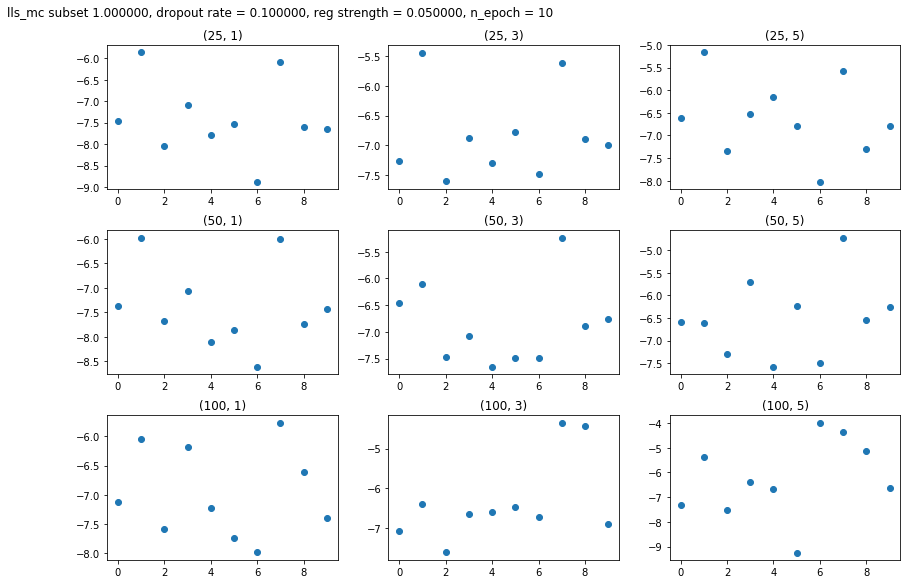

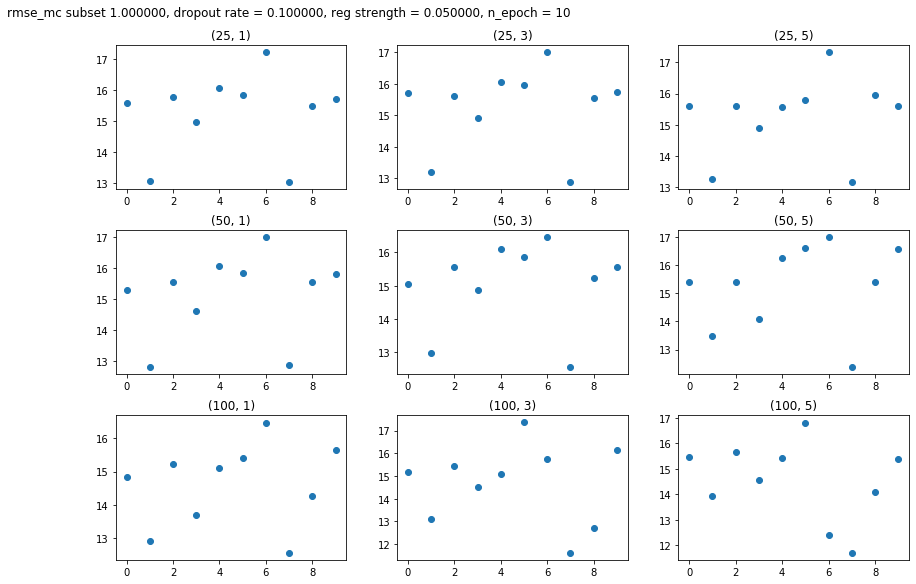

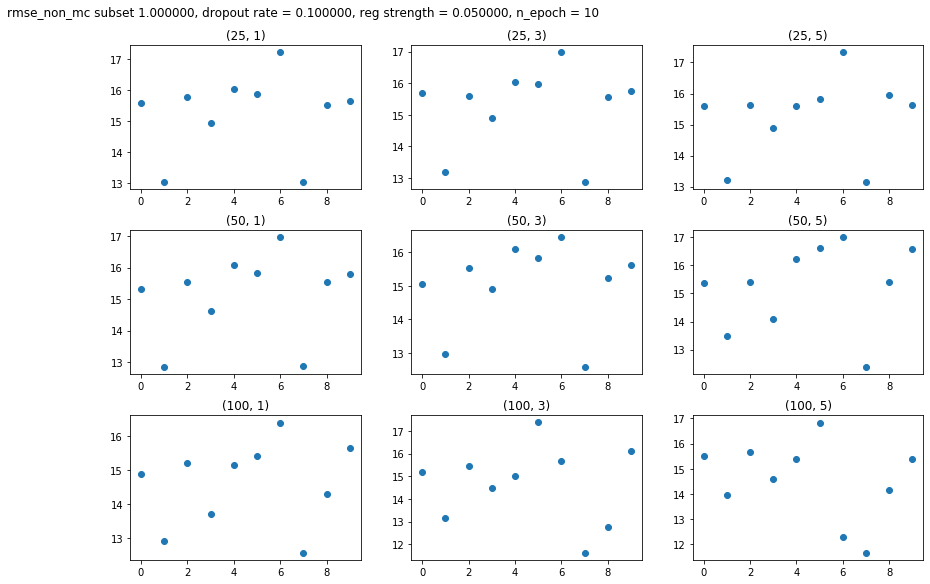

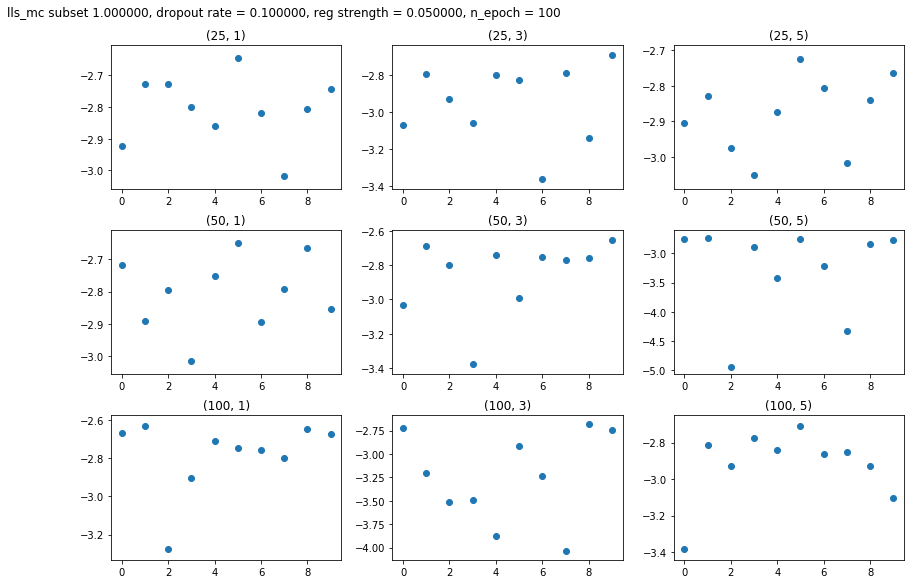

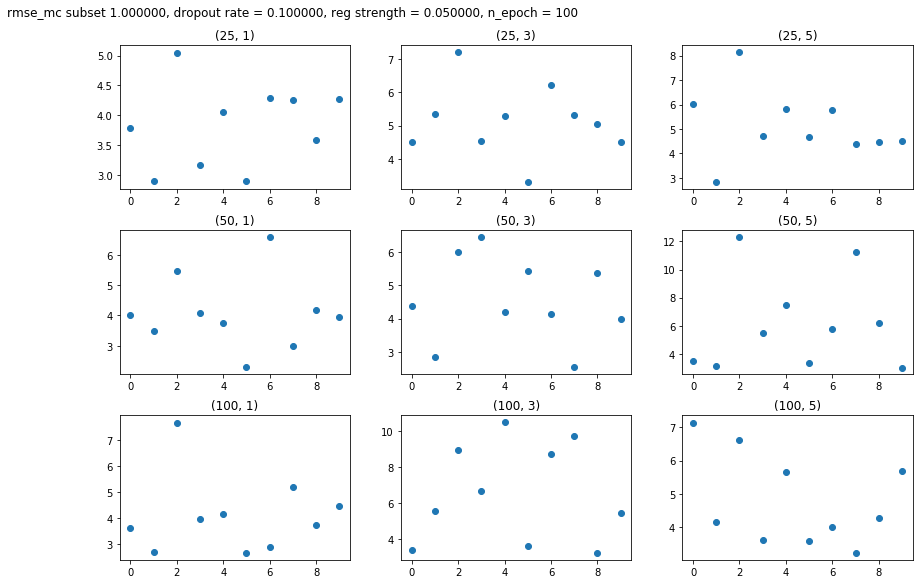

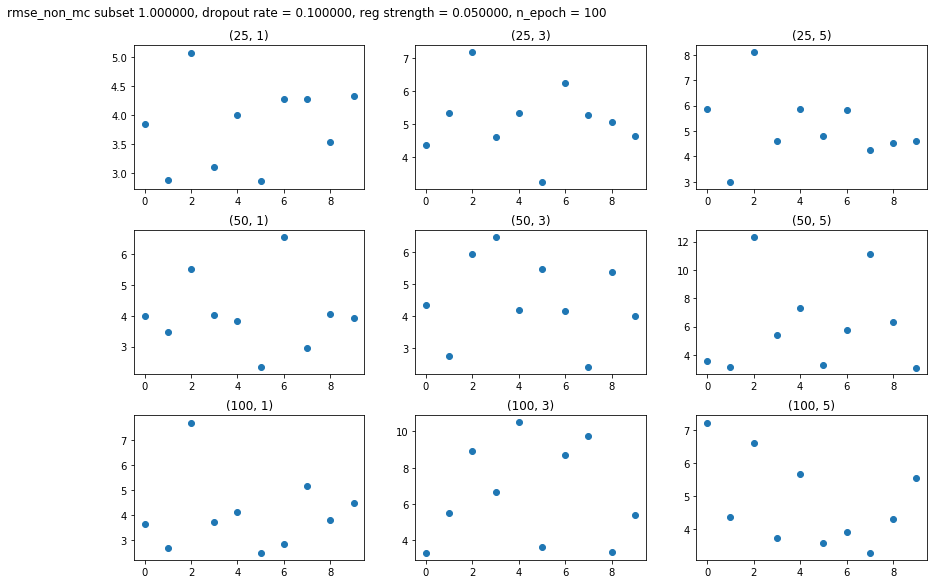

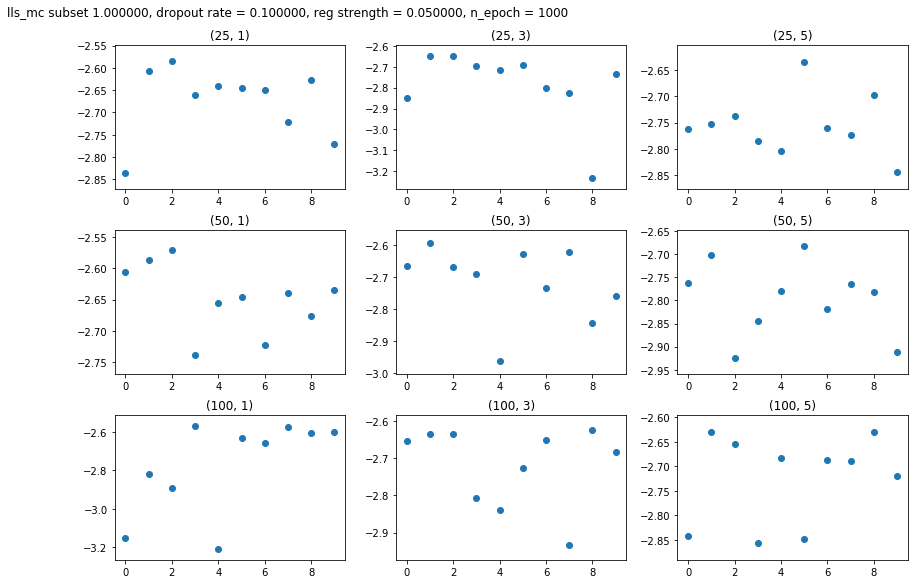

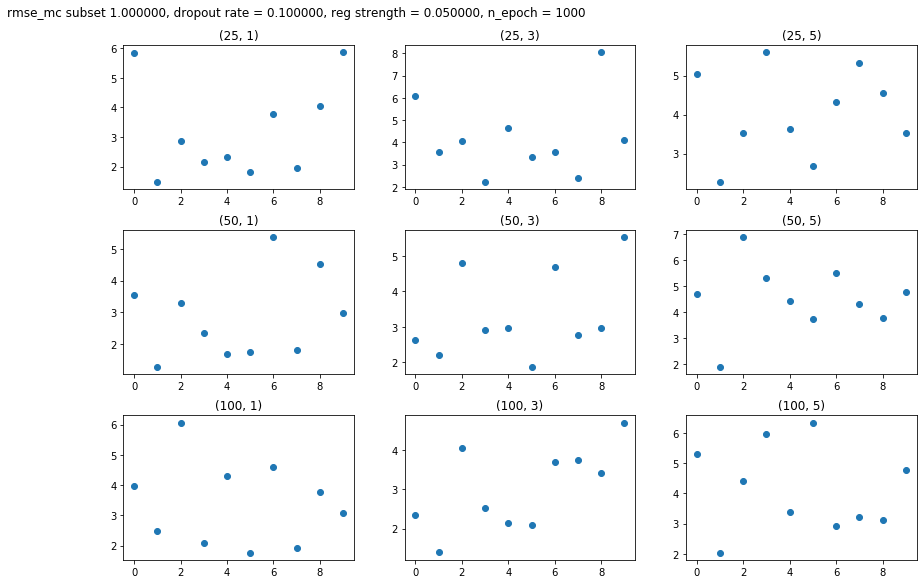

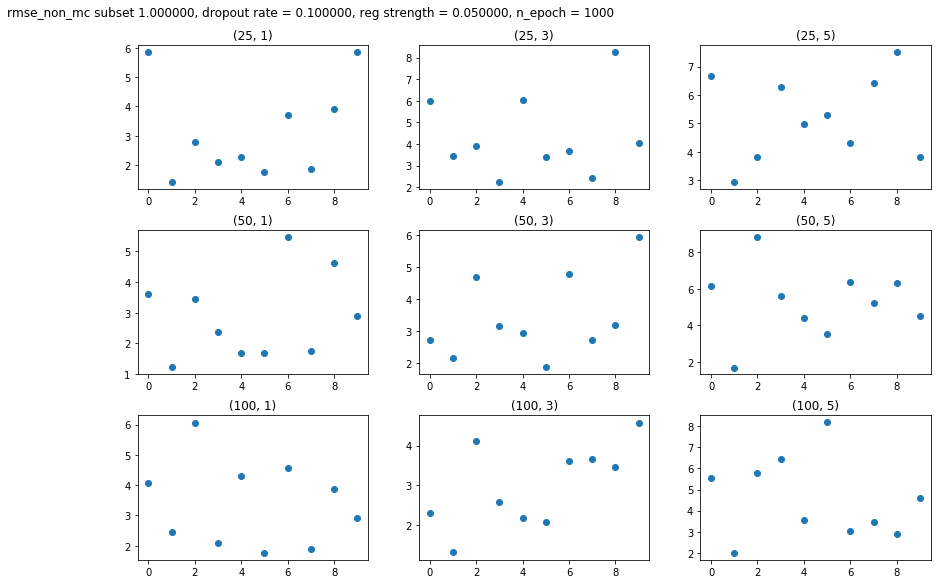

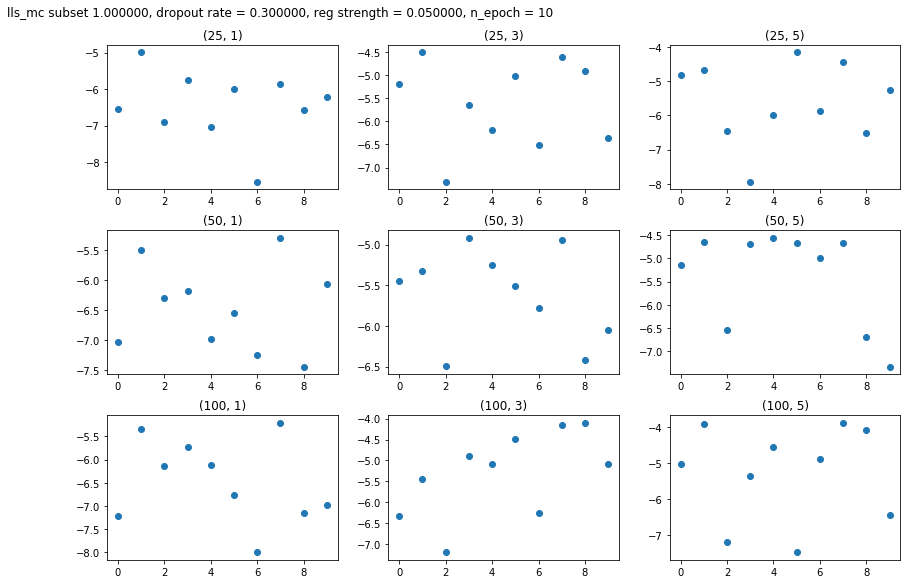

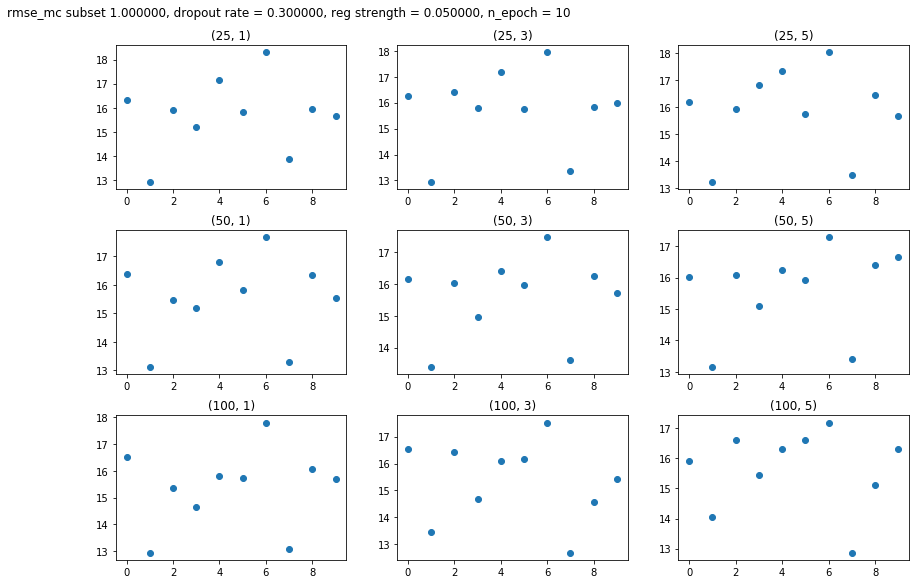

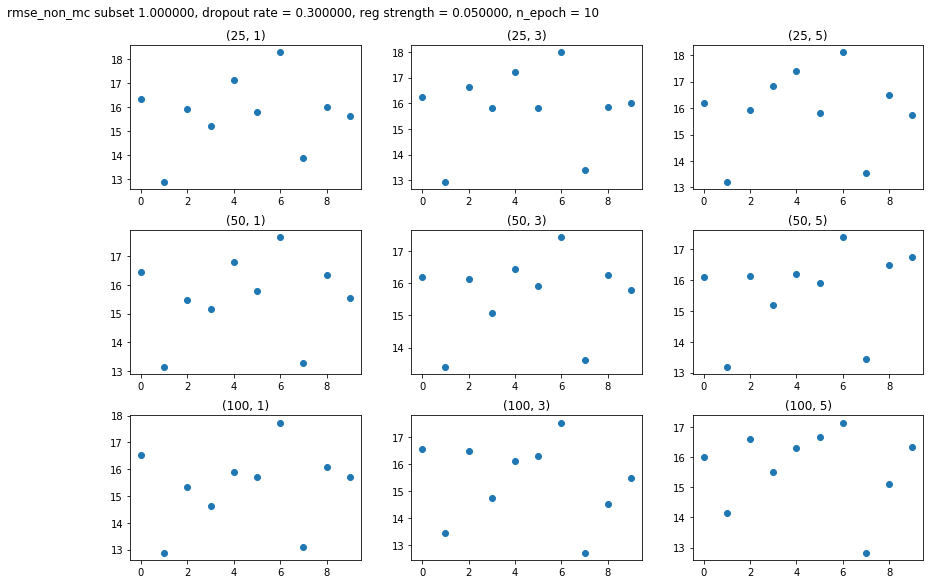

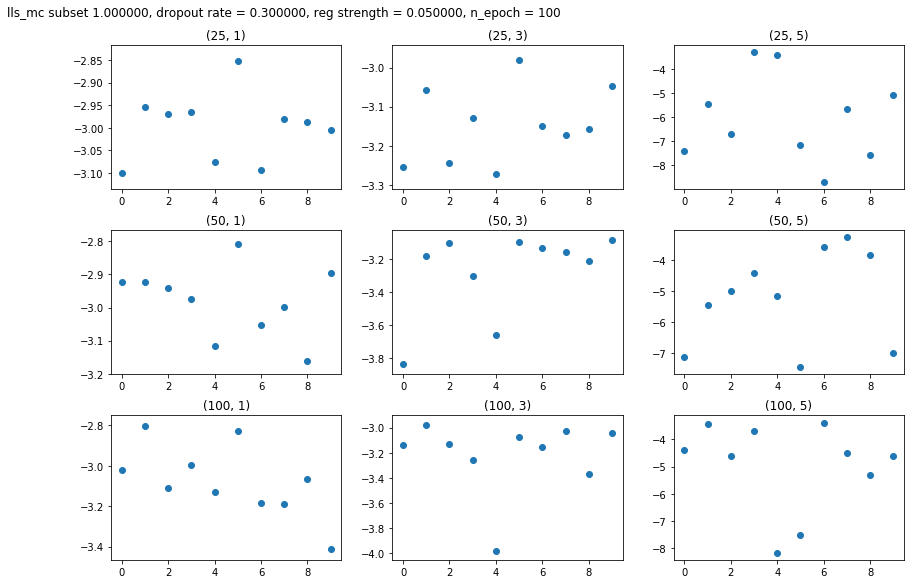

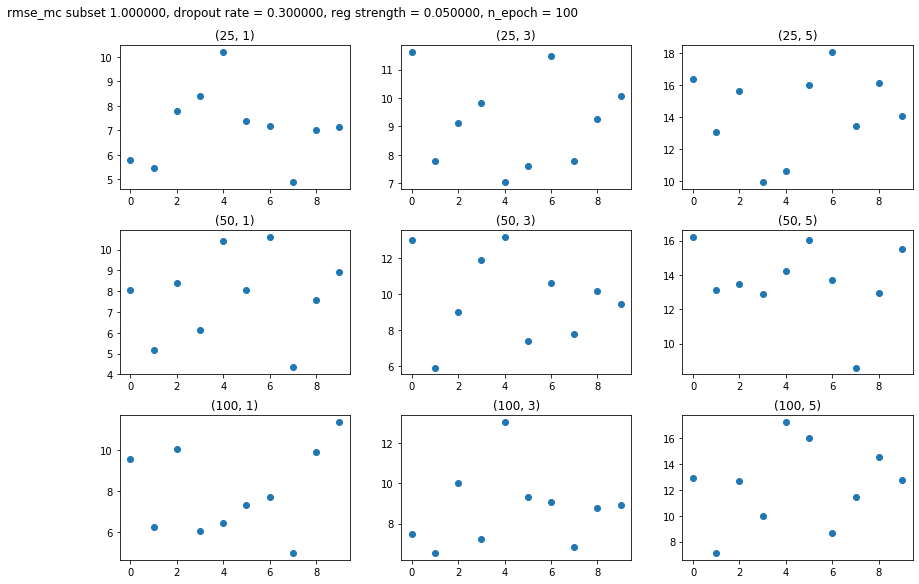

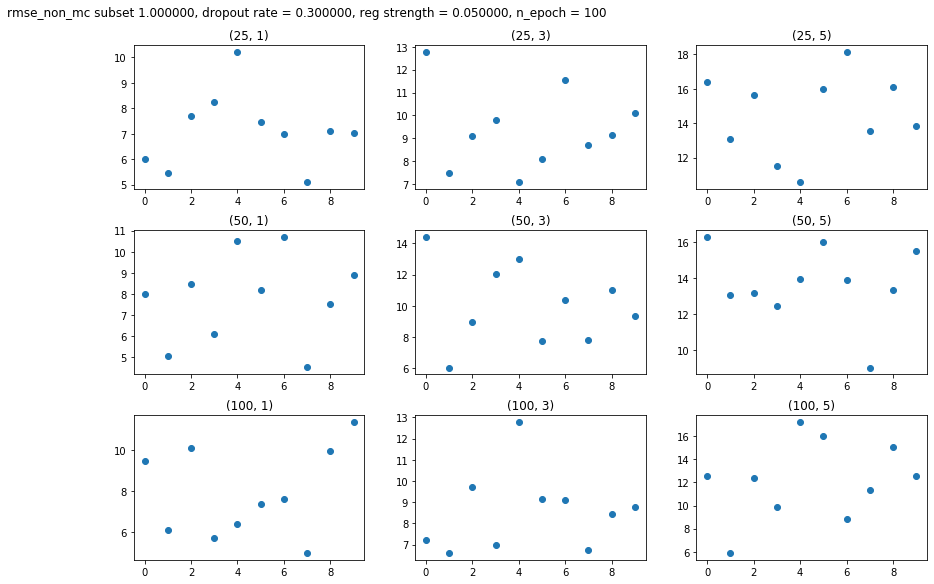

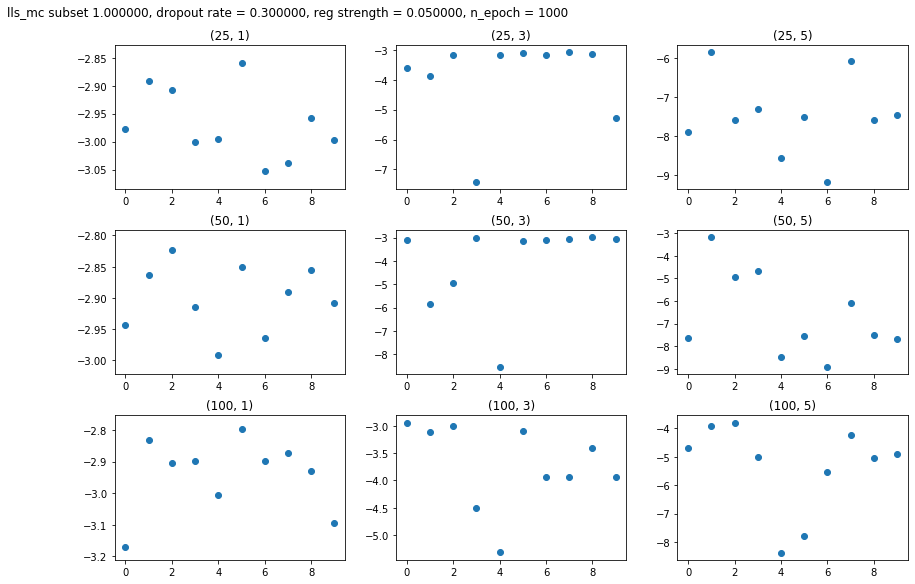

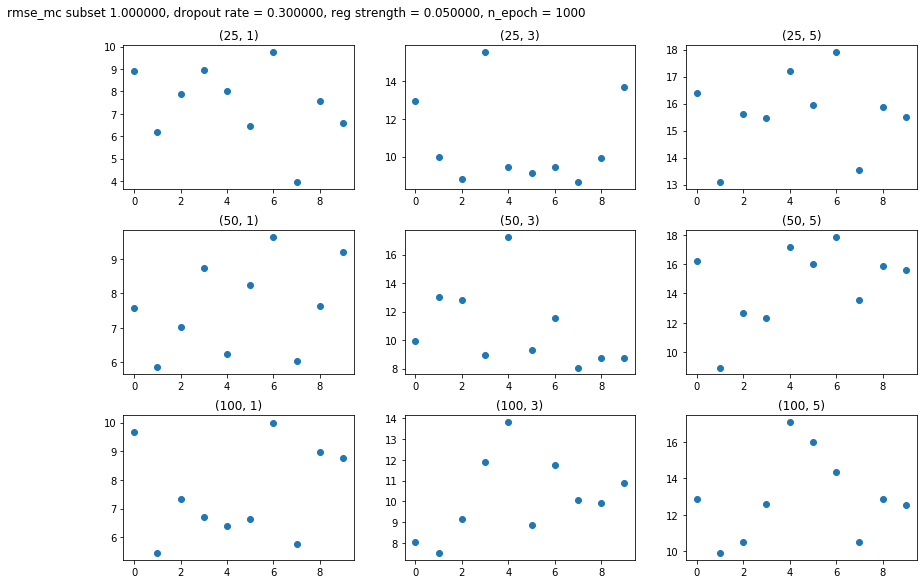

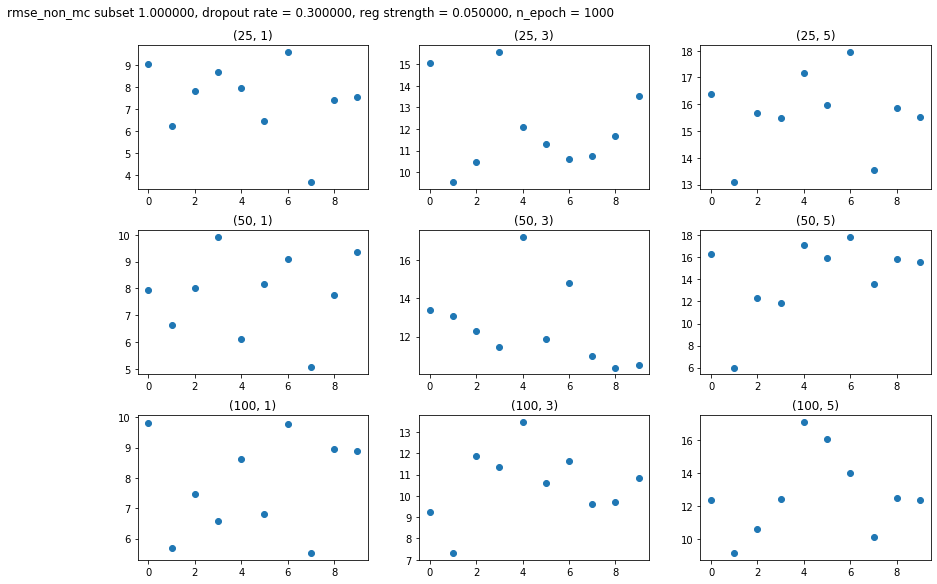

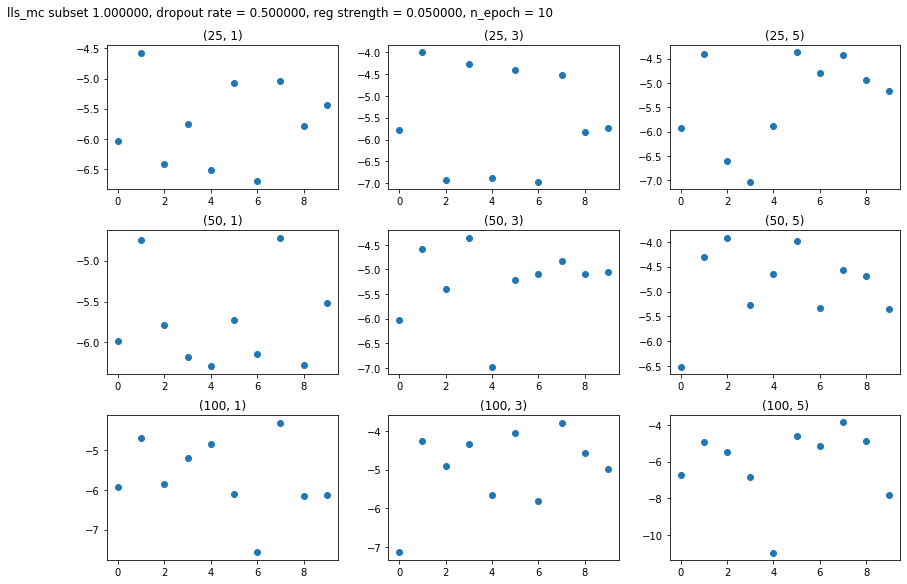

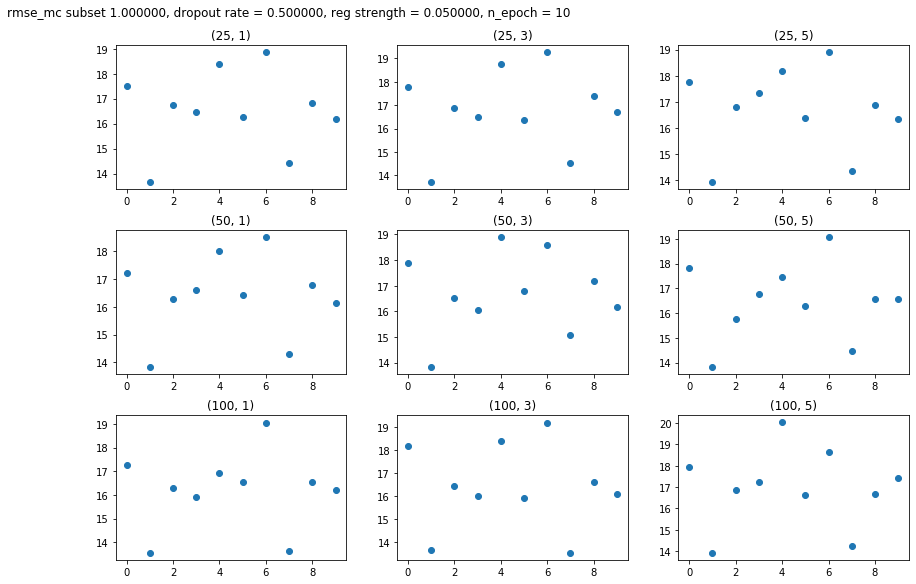

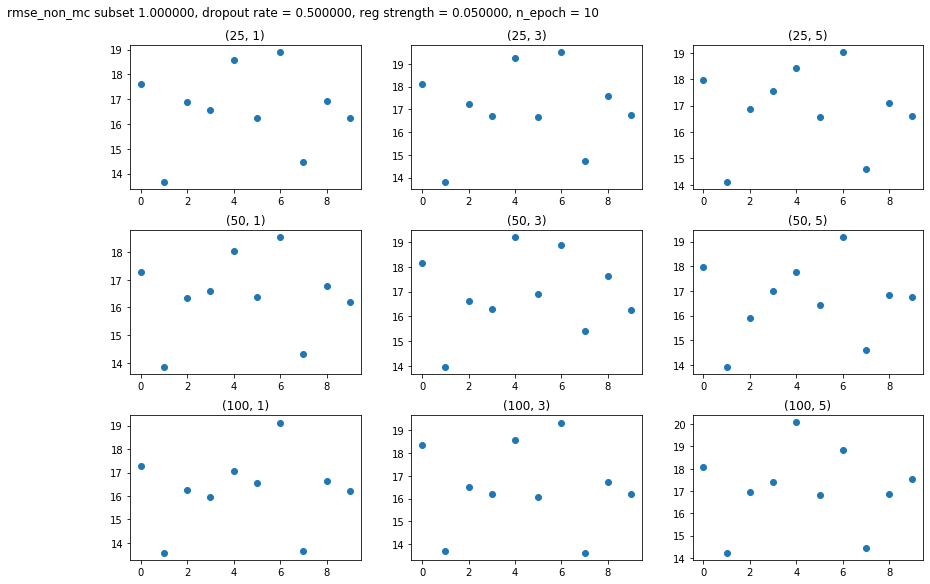

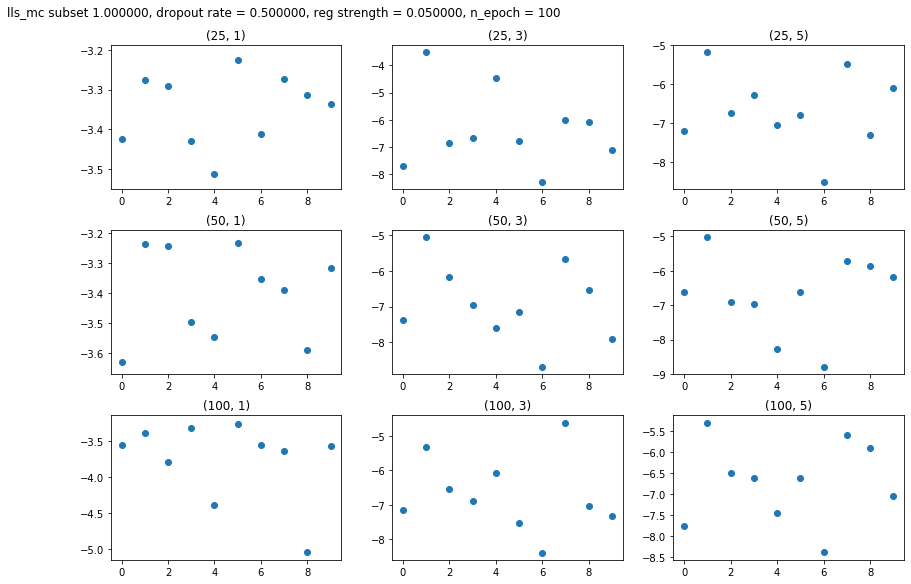

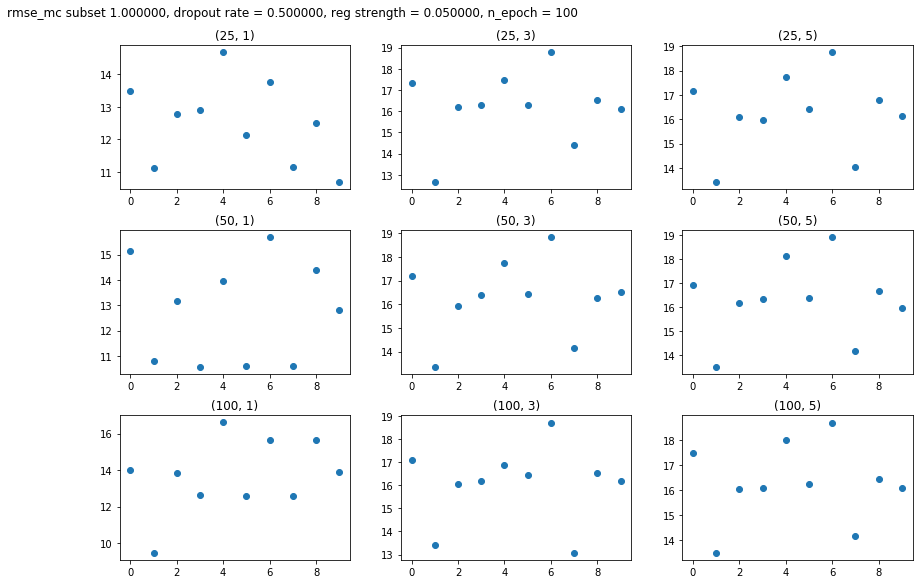

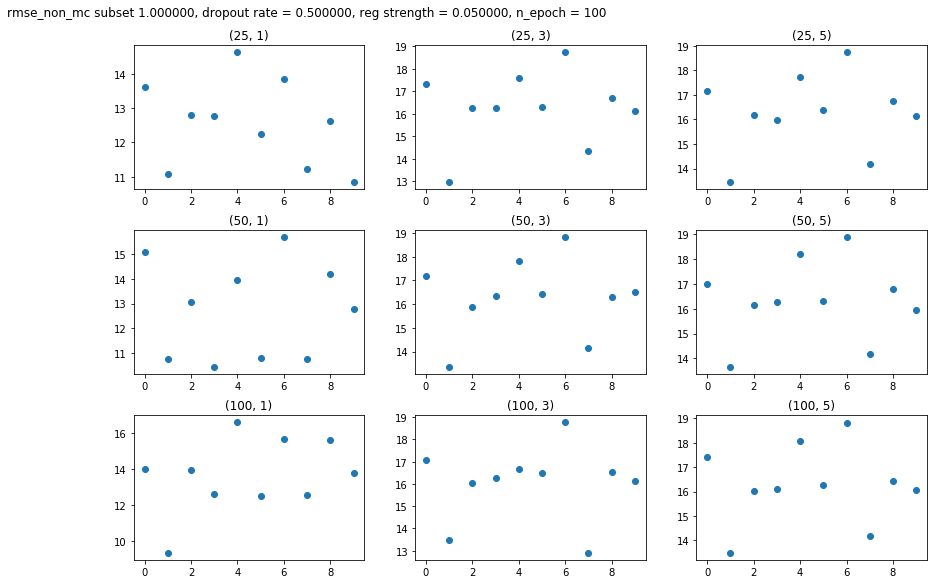

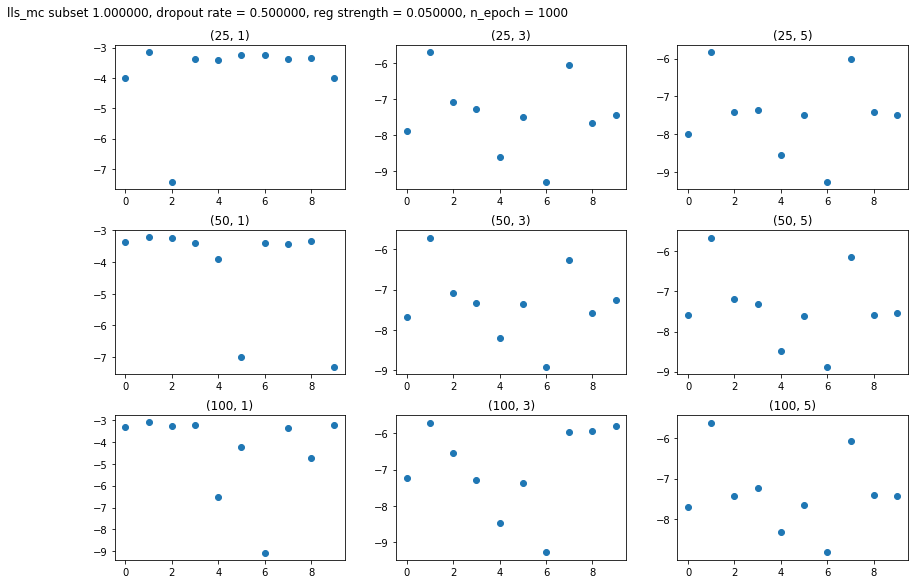

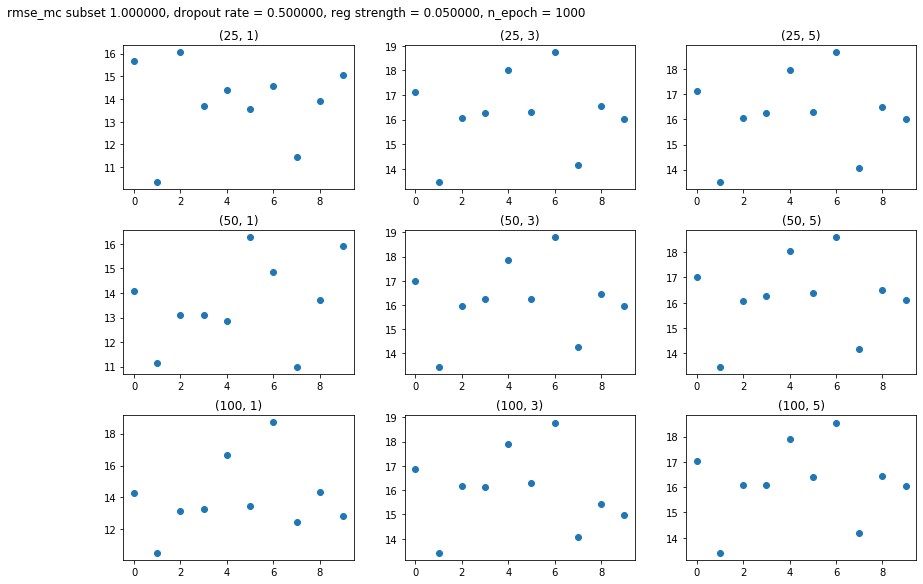

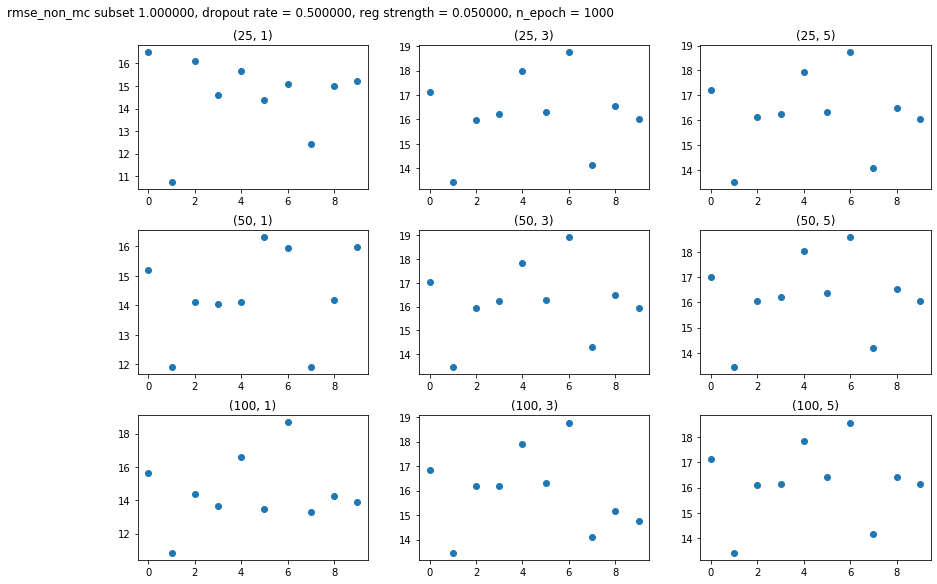

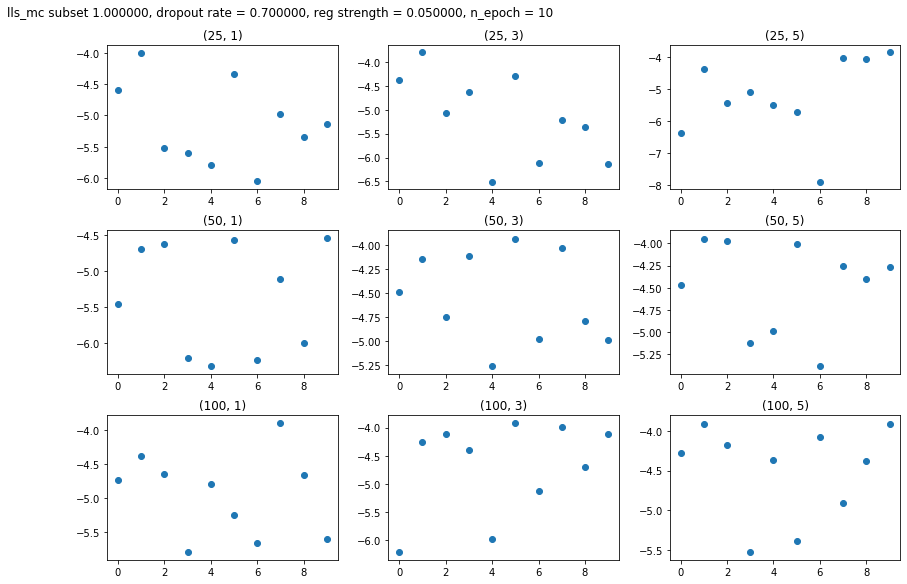

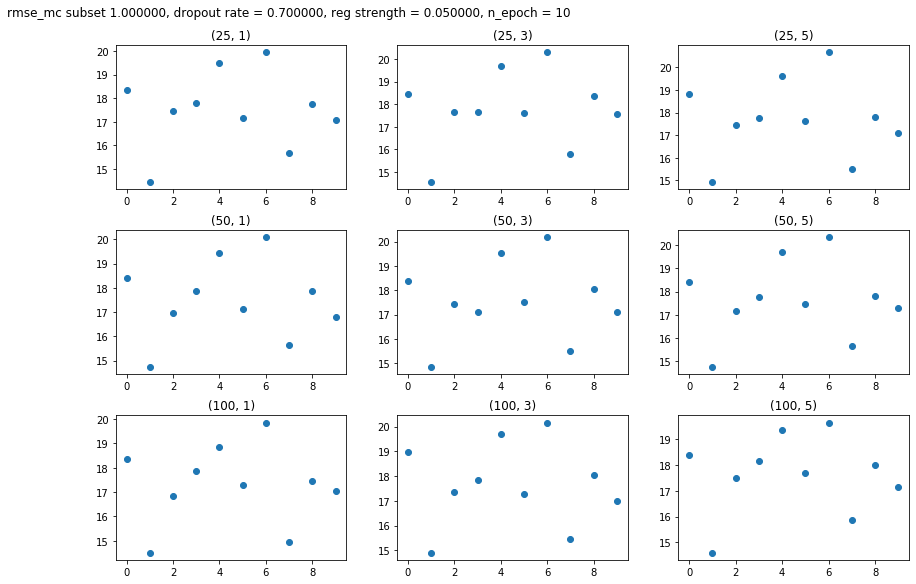

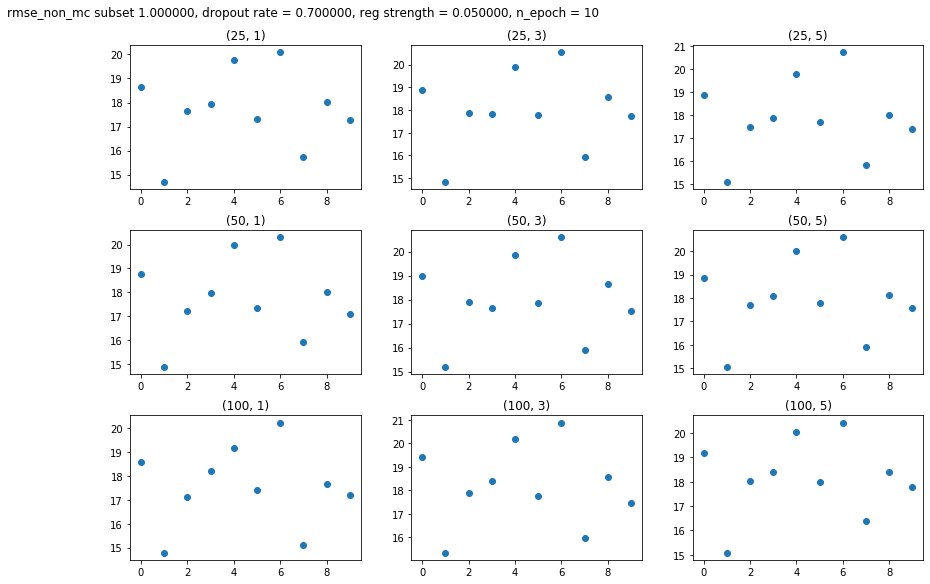

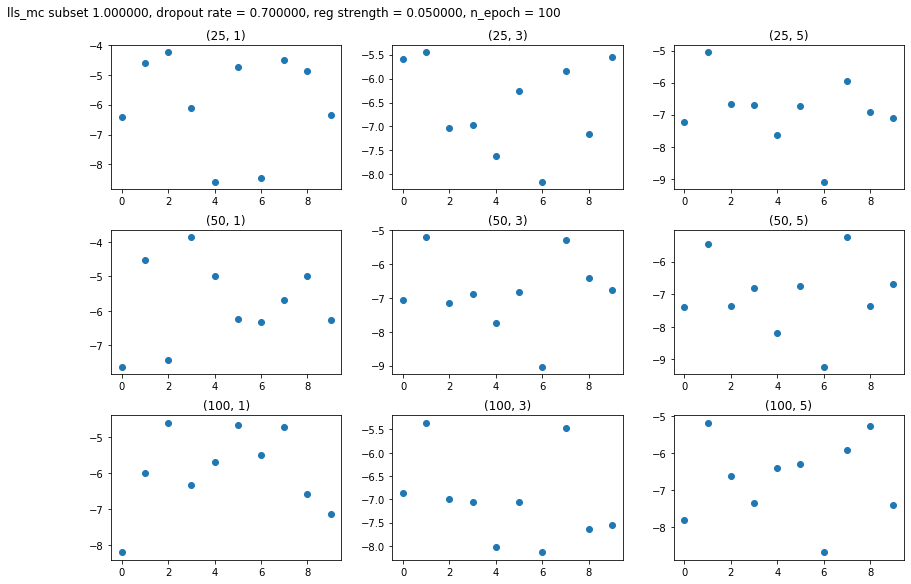

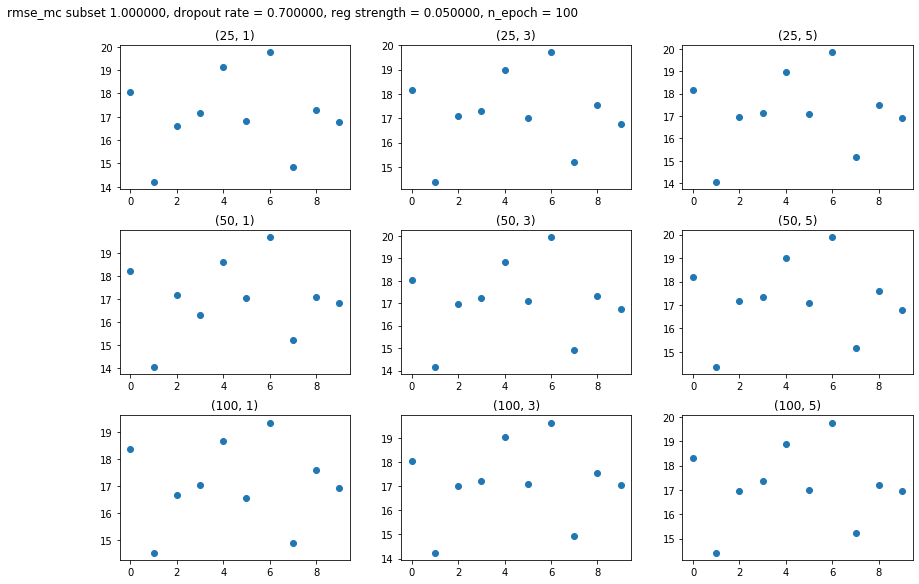

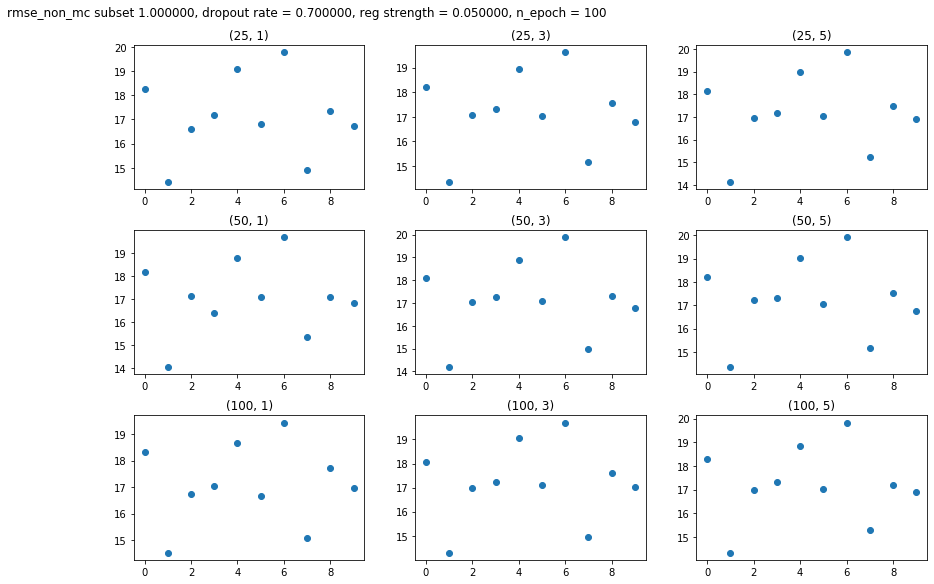

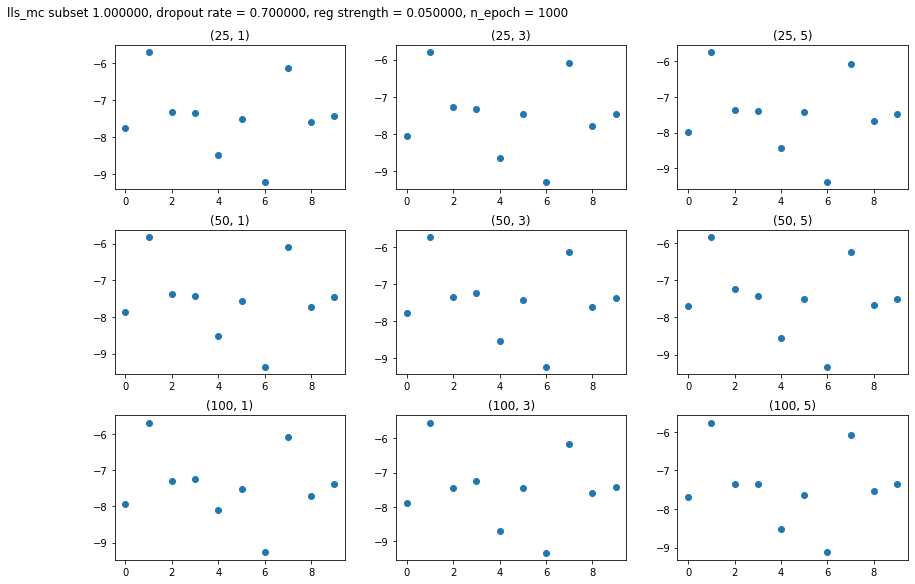

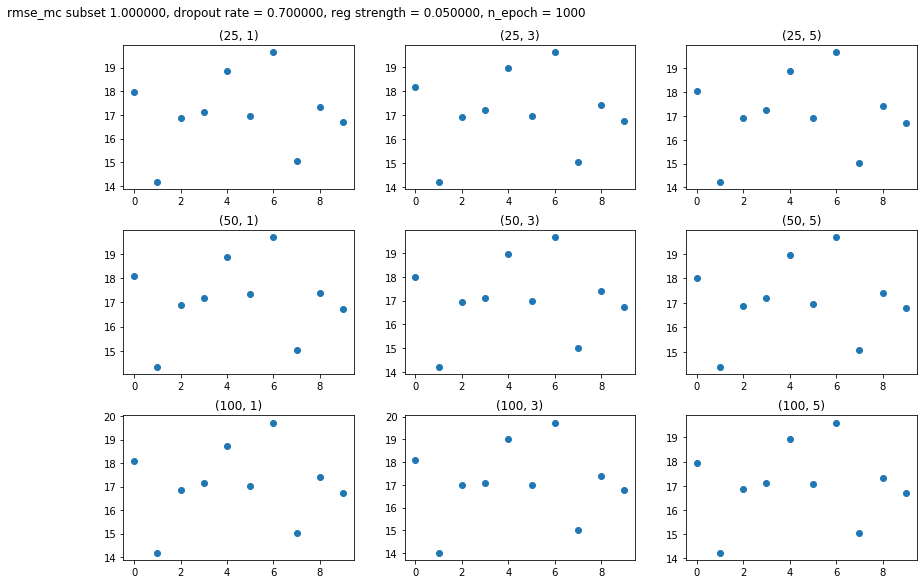

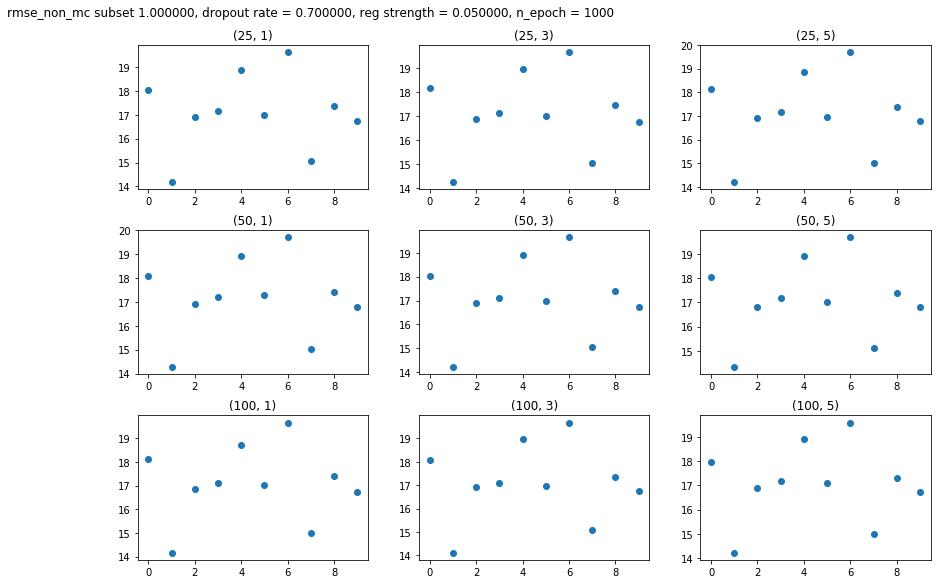

In [8]:
experiment_root_directory = os.path.join(
    './test_results',
    'error_convergence_1',
    uci_dataset_name,
    test_start_time,
)

for subset_prop, dropout_rate, reg_strength, n_epoch in itertools.product(
    subset_proportions, dropout_rates, reg_strengths, n_epochs
):
    for metric_name in ['lls_mc', 'rmse_mc', 'rmse_non_mc']:
        figure_file_name = (
            str(subset_prop)
            + '_' + str(dropout_rate)
            + '_' + str(reg_strength)
            + '_' + str(n_epoch)
            + '_' + metric_name + '.png'
        )
        
        figure_title = (
            metric_name 
            + (' subset %f, dropout rate = %f, reg strength = %f, n_epoch = %d' % (subset_prop, dropout_rate, reg_strength, n_epoch))
        )

        fig, ax = plt.subplots(len(network_hidden_dims), len(network_hidden_layers))

        fig.tight_layout(pad=2, rect=[0, 0.00, 2, 2])    

        plt_subplot_current_row = 0
        
        for hidden_dim in network_hidden_dims:
            plt_subplot_current_column = 0

            for n_layer in network_hidden_layers:
                # Open the score file
                score_file_path = os.path.join(
                    experiment_root_directory,
                    (
                        str(subset_prop) 
                        + '_' + str(hidden_dim)
                        + '_' + str(n_layer) 
                        + '_' + str(dropout_rate) 
                        + '_' + str(reg_strength)
                        + '_' + str(n_epoch)
                    ),
                    metric_name + '.txt',
                )

                scores = np.loadtxt(score_file_path).T
                
                #if metric_name in ('rmse_mc', 'rmse_non_mc'):
                #    ax[plt_subplot_current_row, plt_subplot_current_column].set_ylim([0, 20])
                #elif metric_name == 'lls_mc':
                #    ax[plt_subplot_current_row, plt_subplot_current_column].set_ylim([-20, 0])

                ax[plt_subplot_current_row, plt_subplot_current_column].scatter(scores[0], scores[1])

                ax[plt_subplot_current_row, plt_subplot_current_column].set_title(str((hidden_dim, n_layer)))

                plt_subplot_current_column += 1

            plt_subplot_current_row += 1

        fig.suptitle(figure_title, y=2.05)
        
        plt.savefig(
            os.path.join(experiment_root_directory, figure_file_name),
            dpi=600,
            bbox_inches='tight',
        )
        
        plt.show()

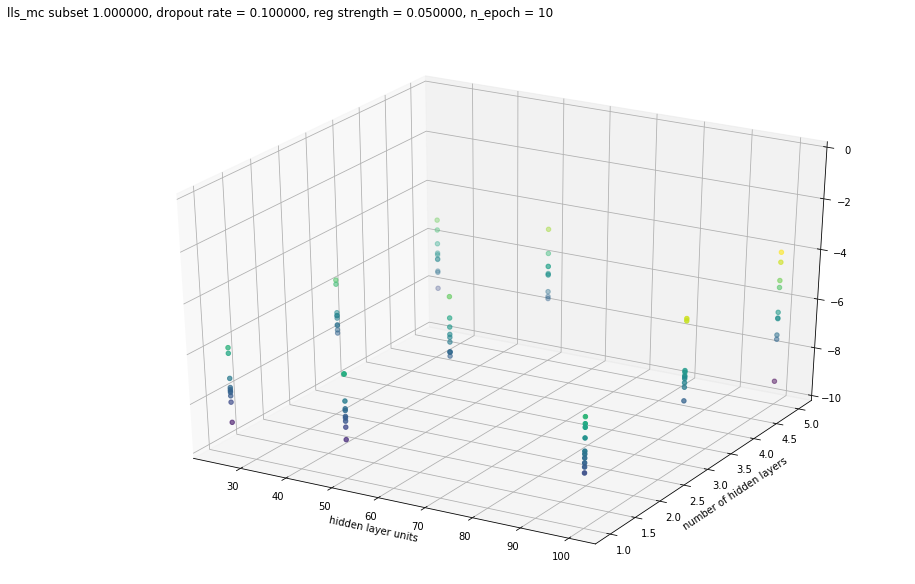

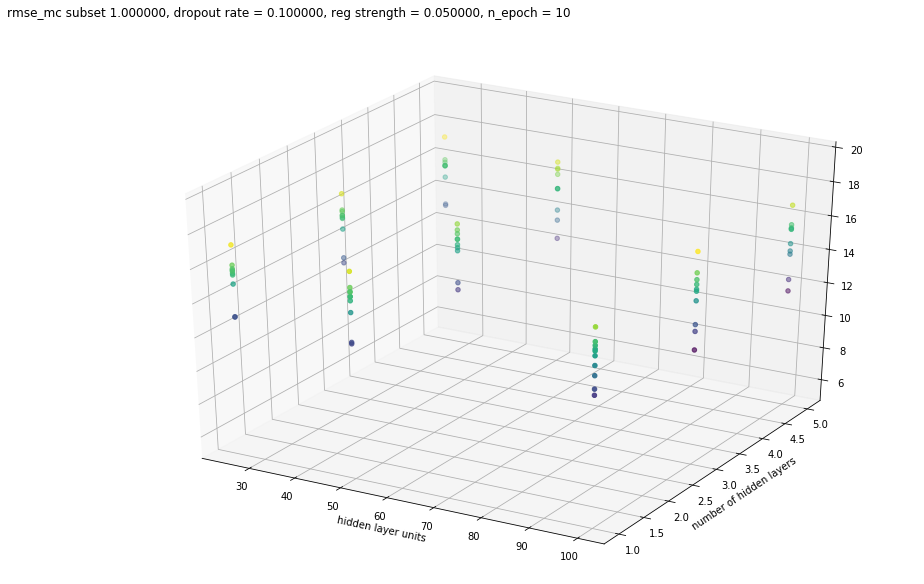

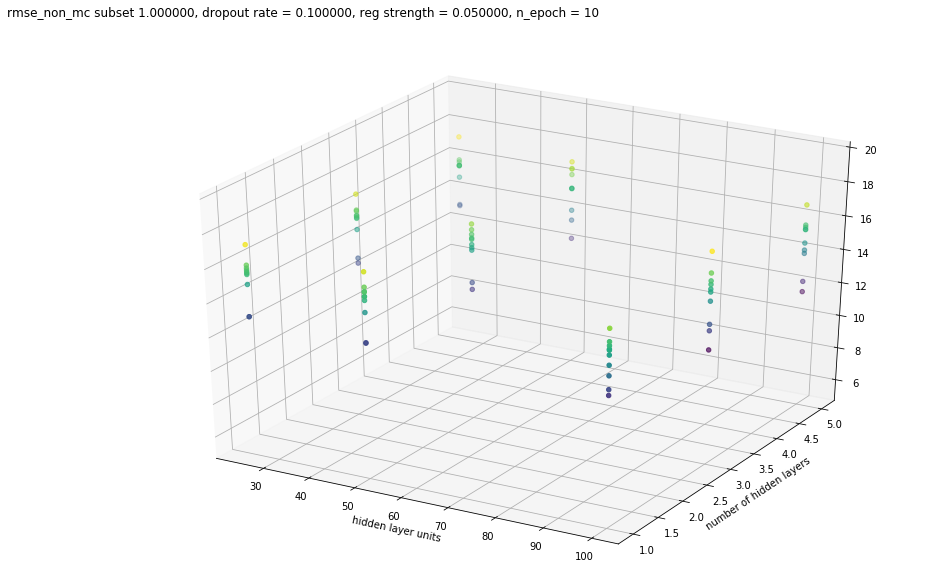

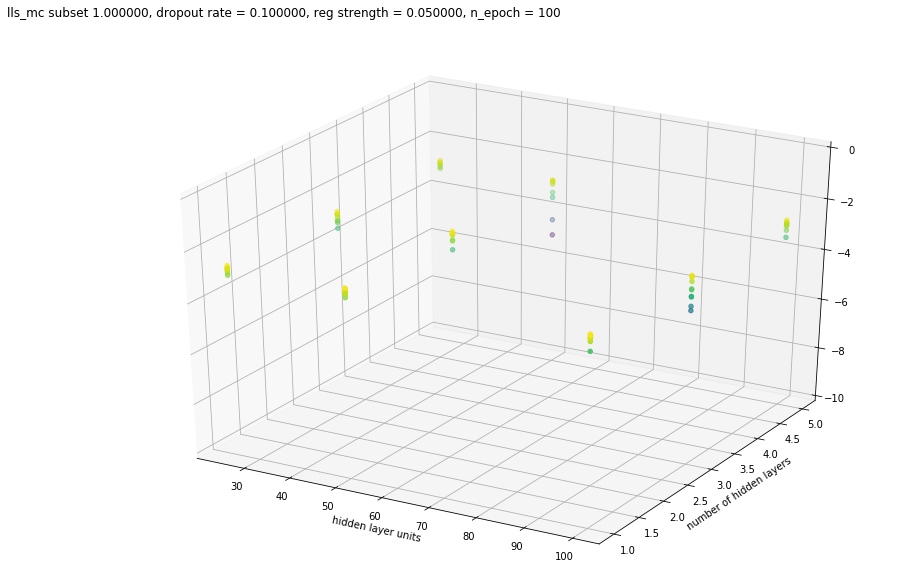

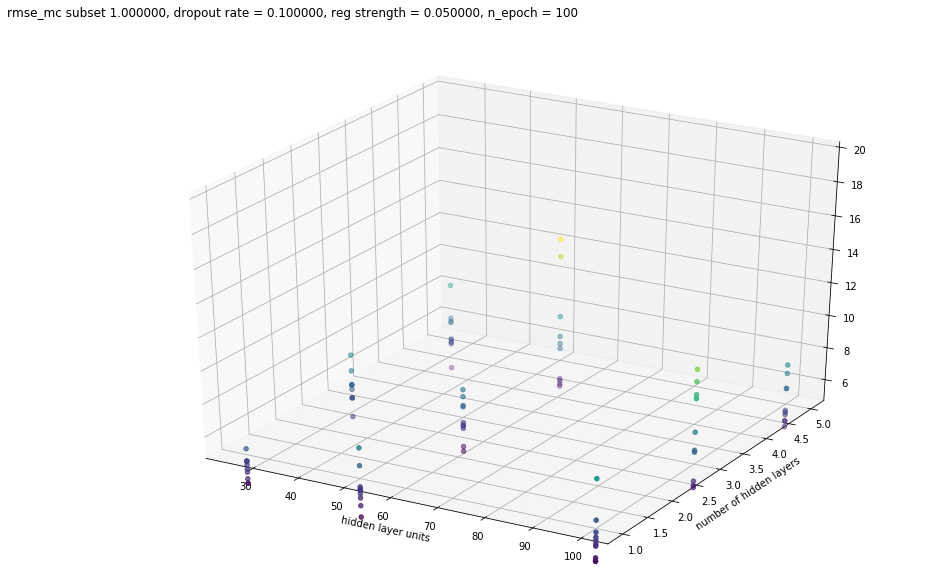

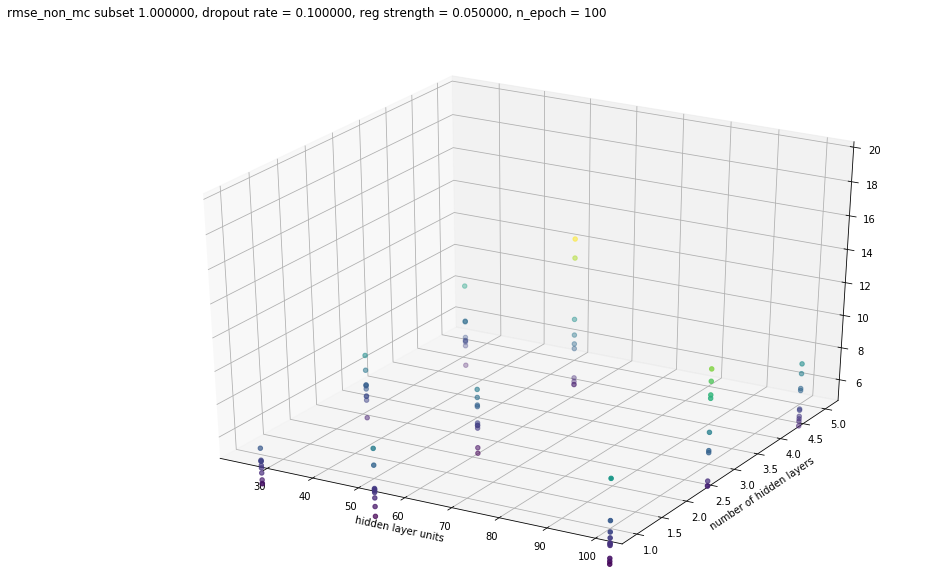

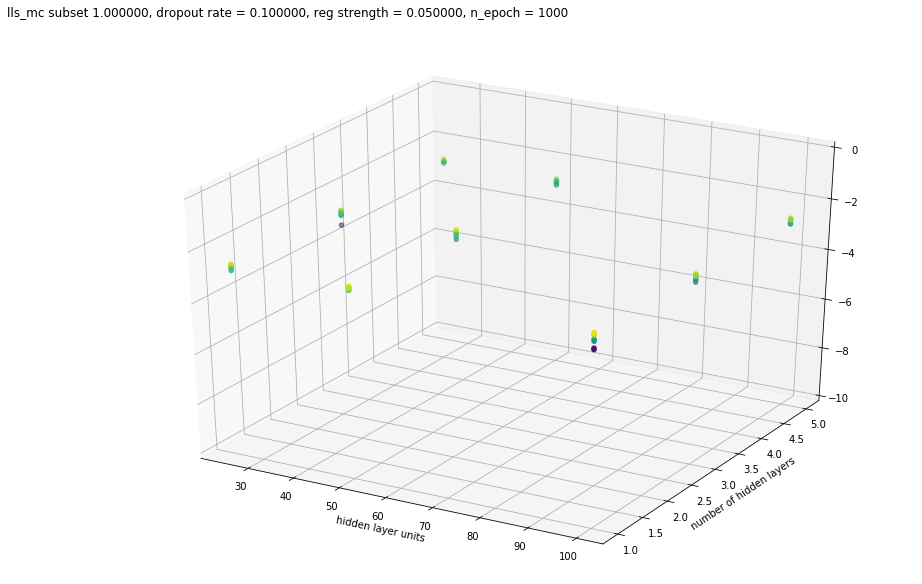

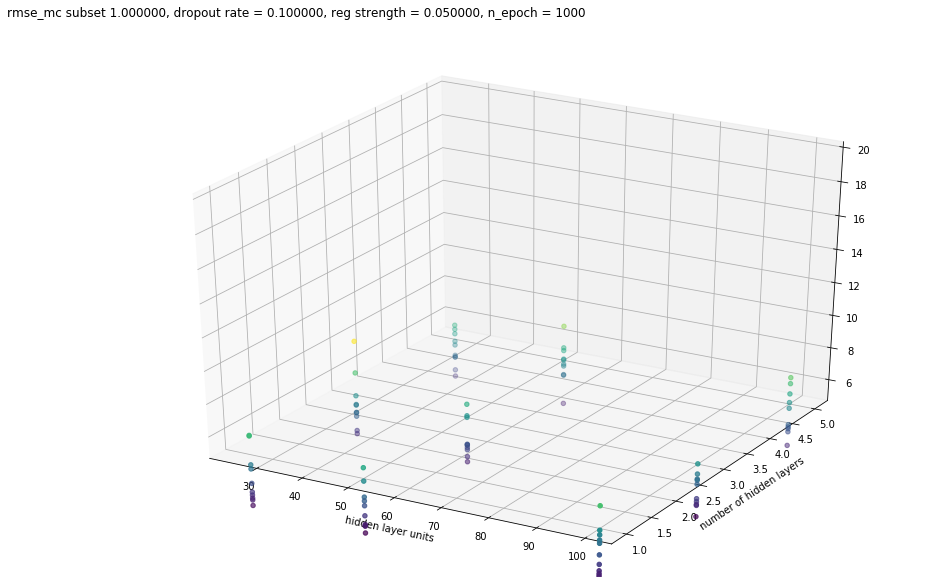

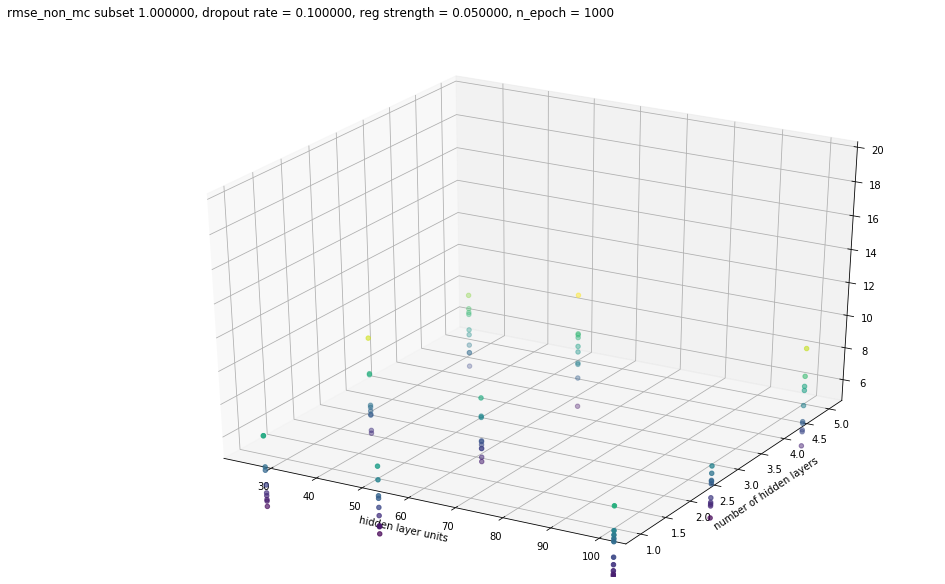

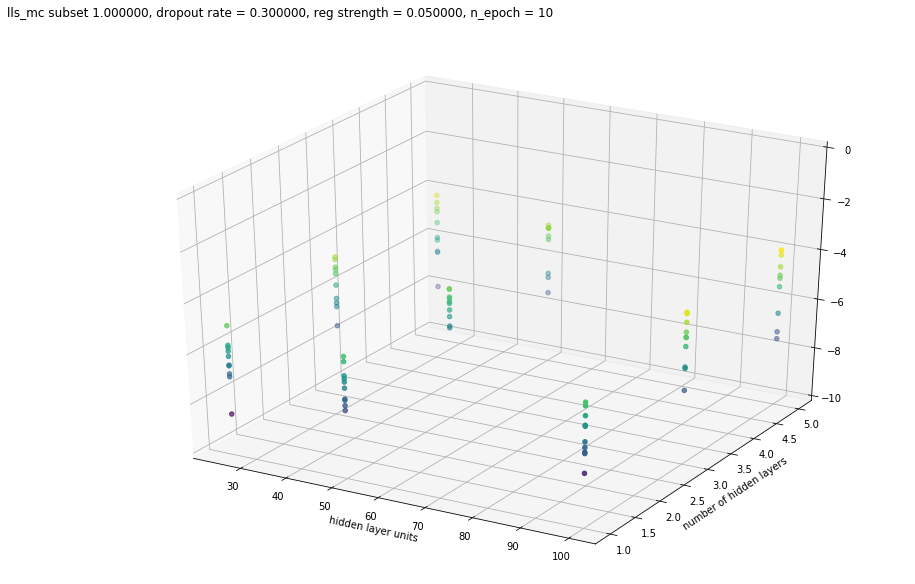

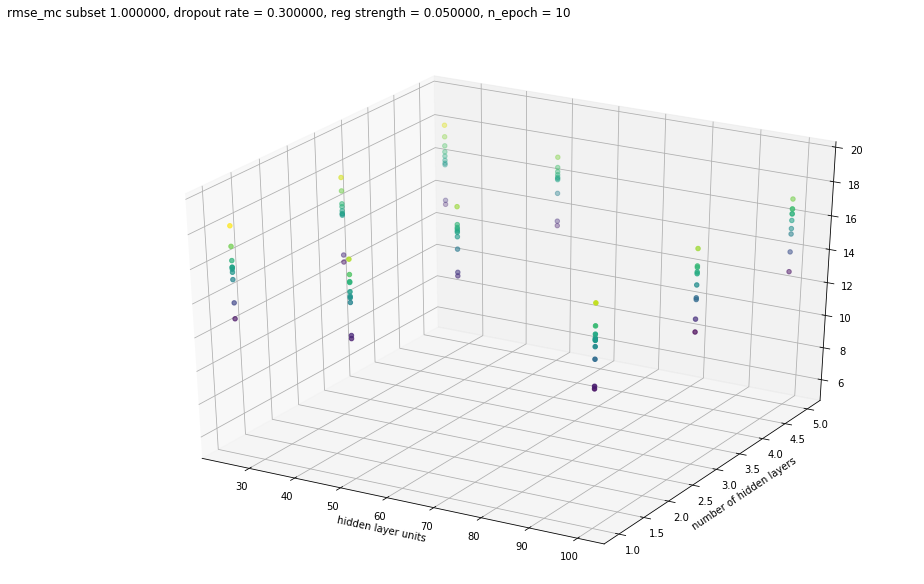

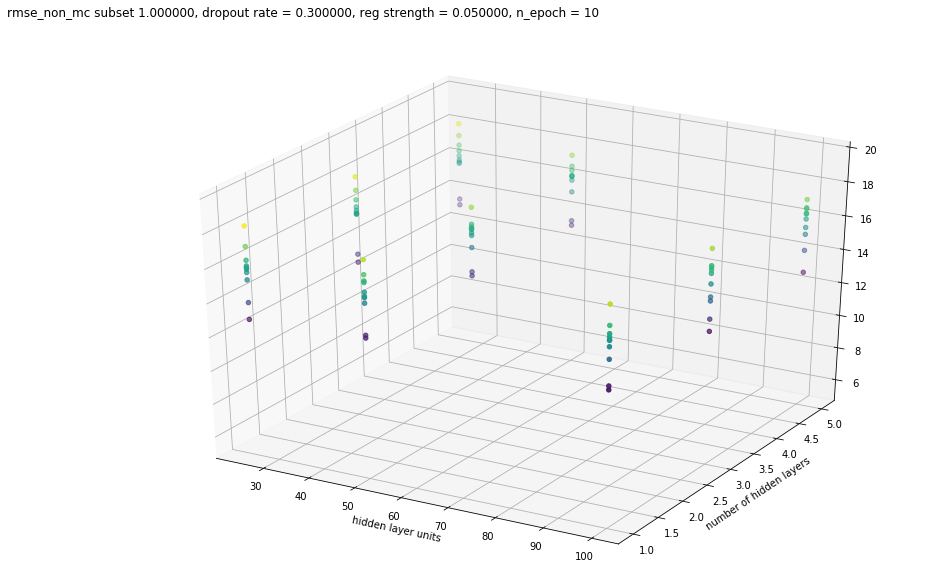

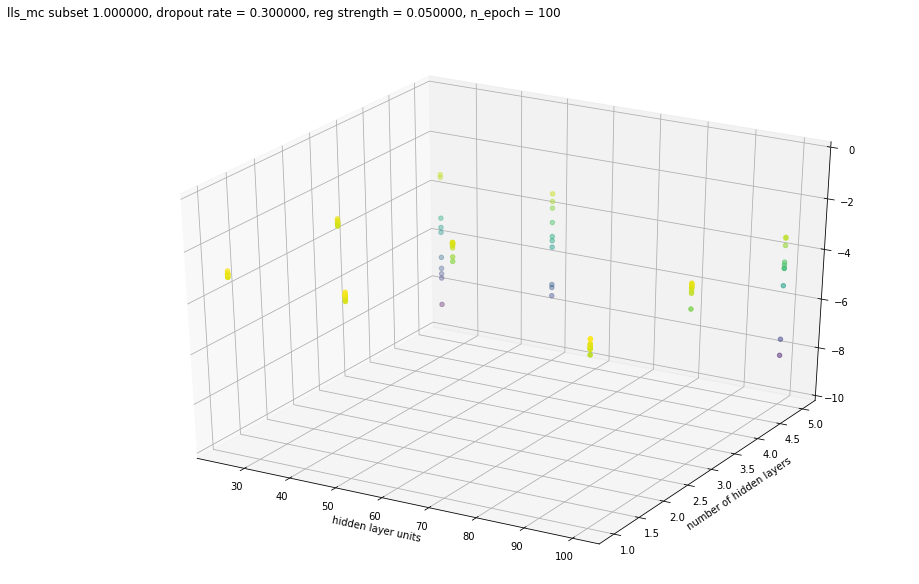

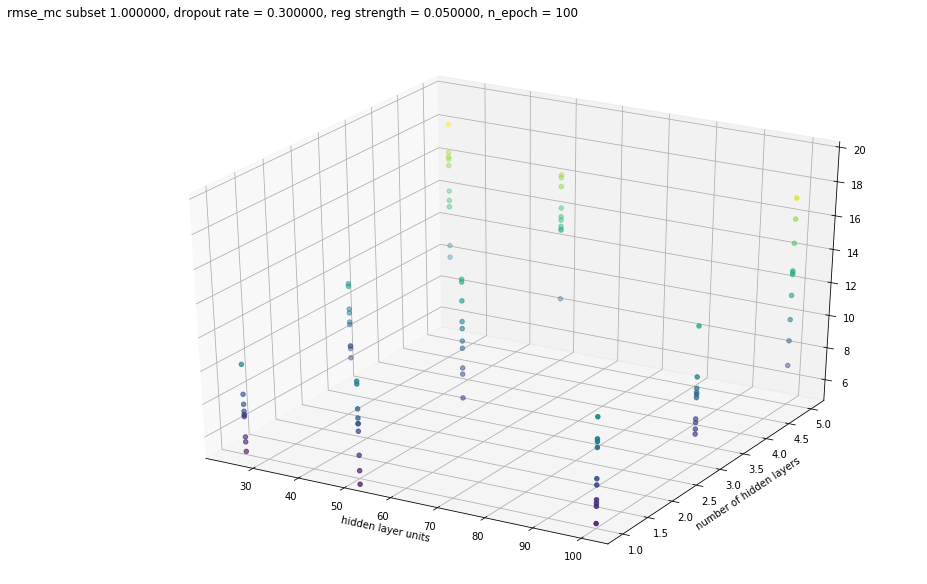

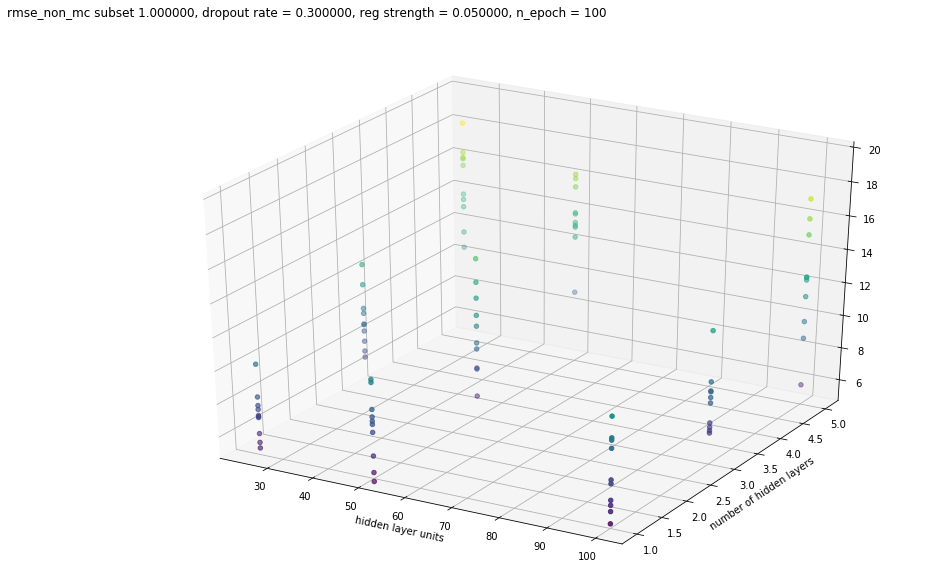

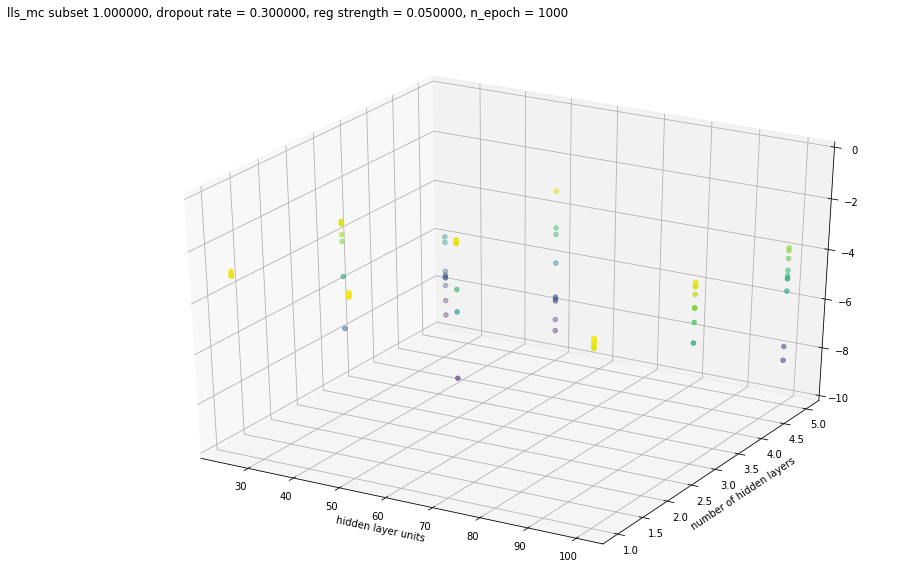

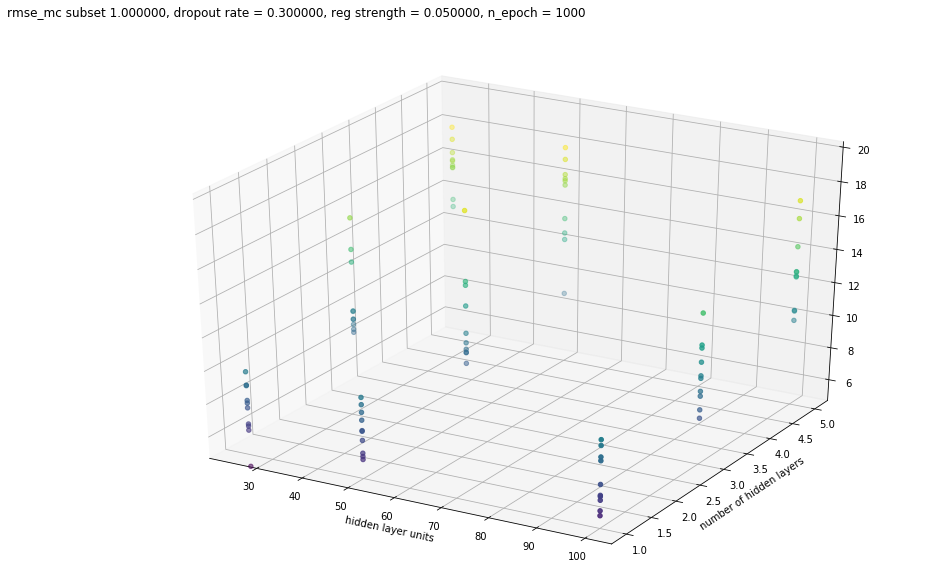

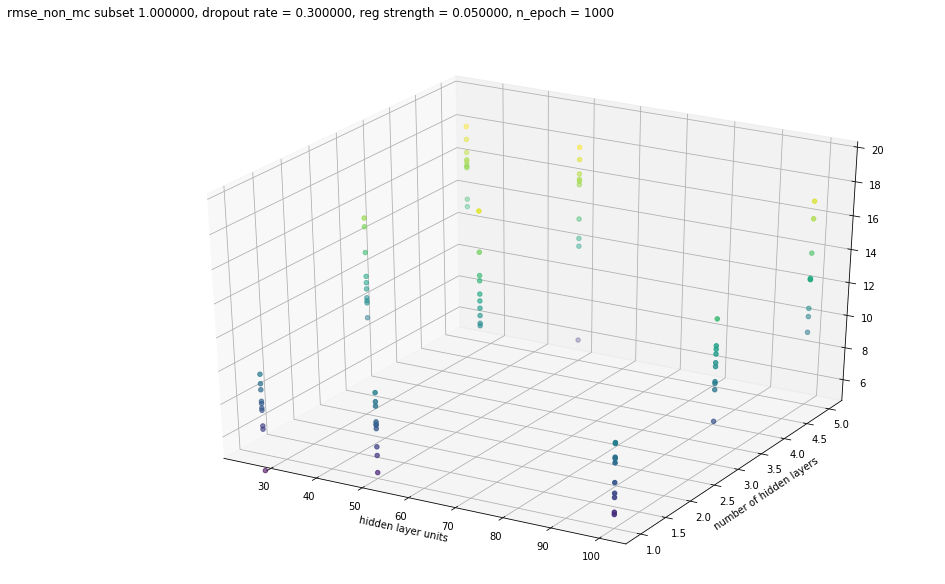

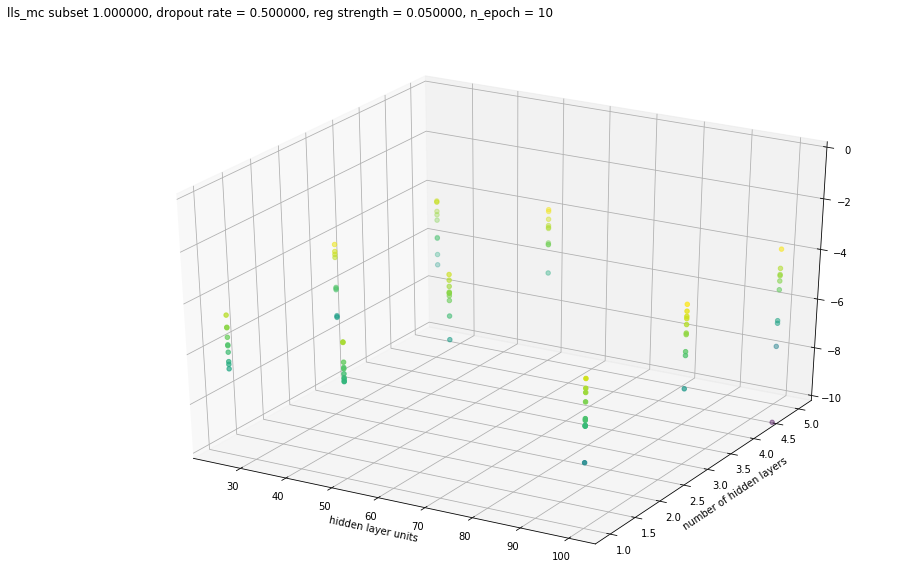

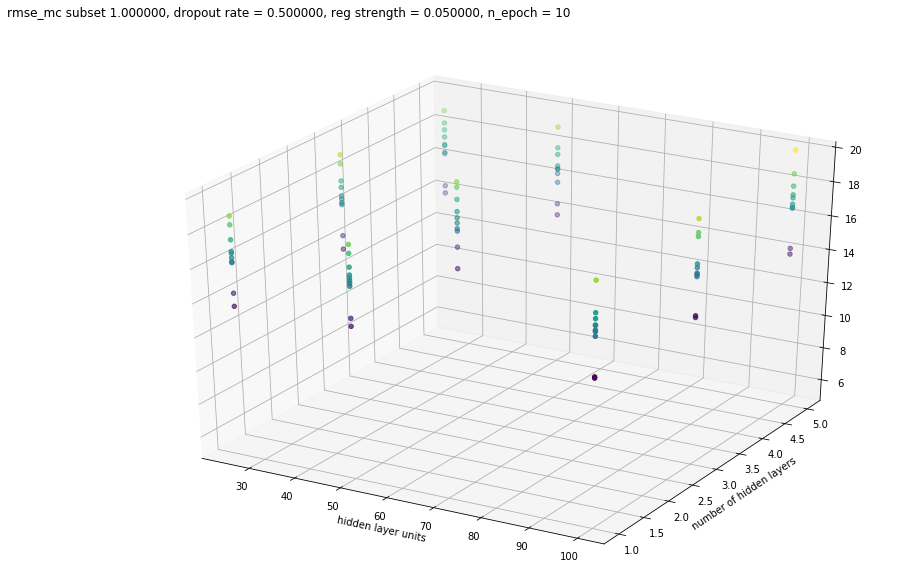

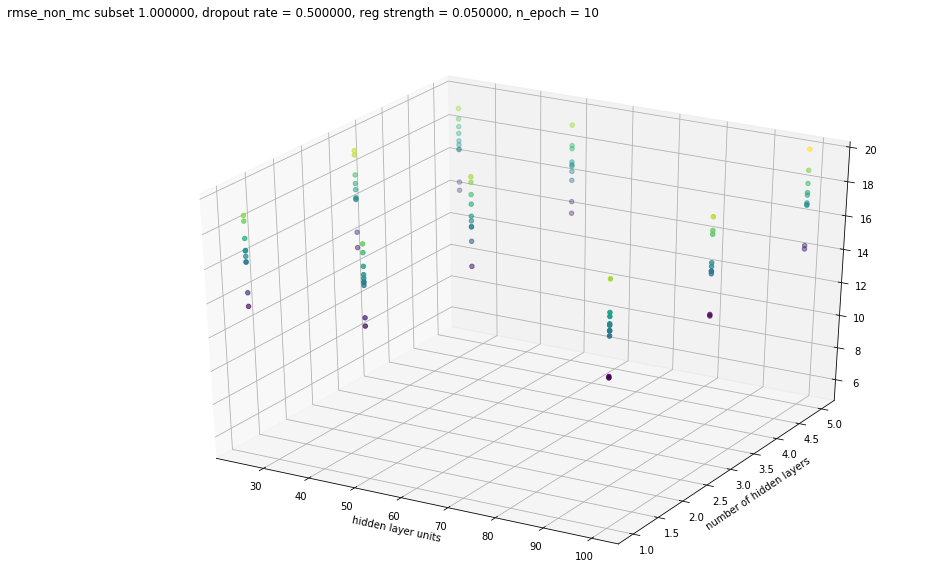

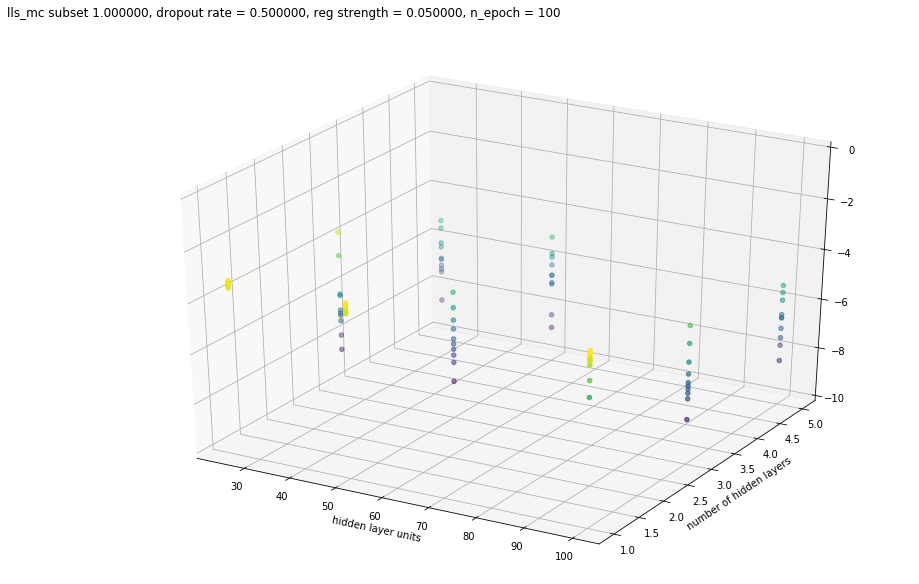

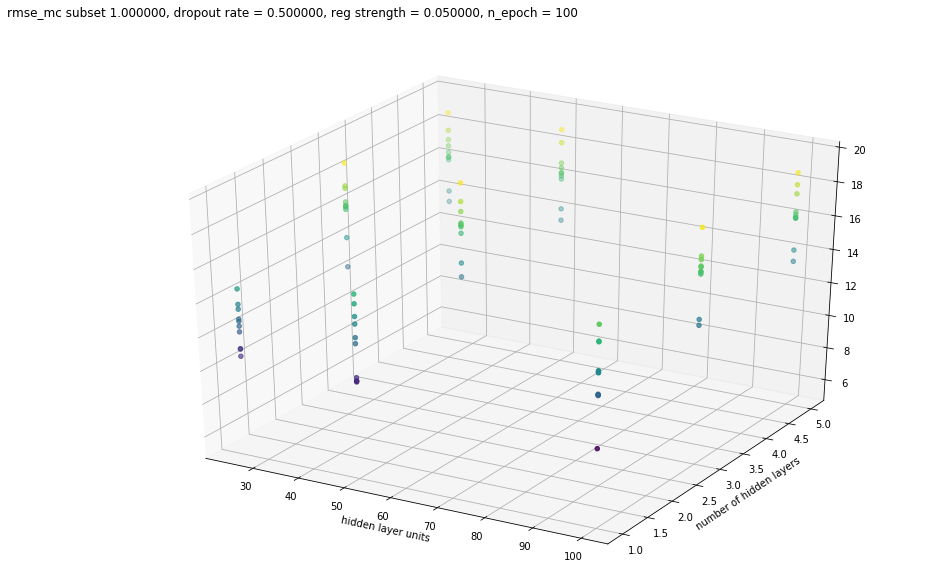

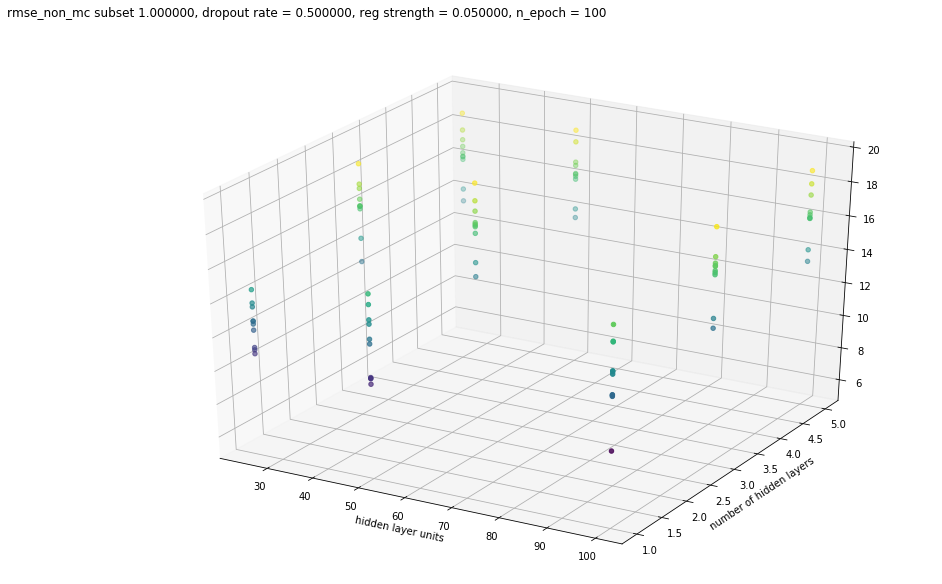

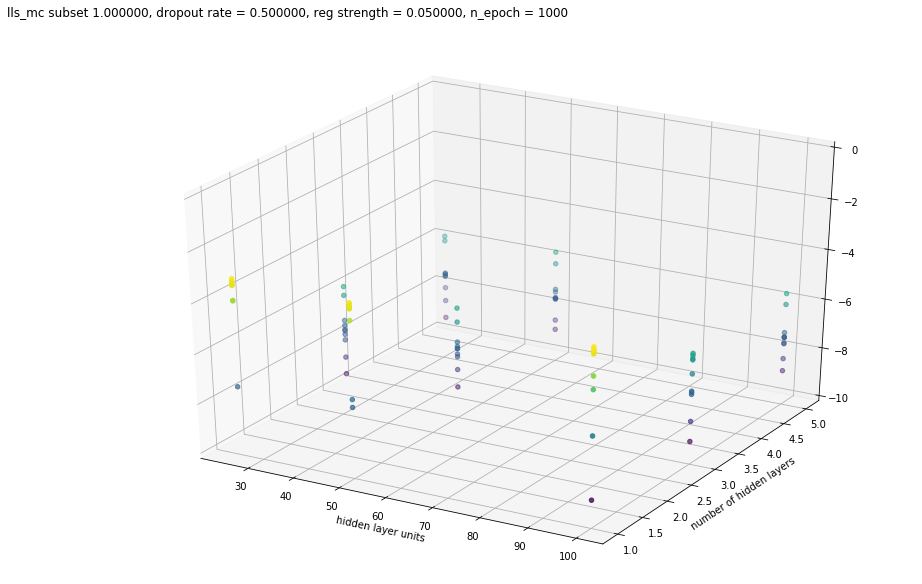

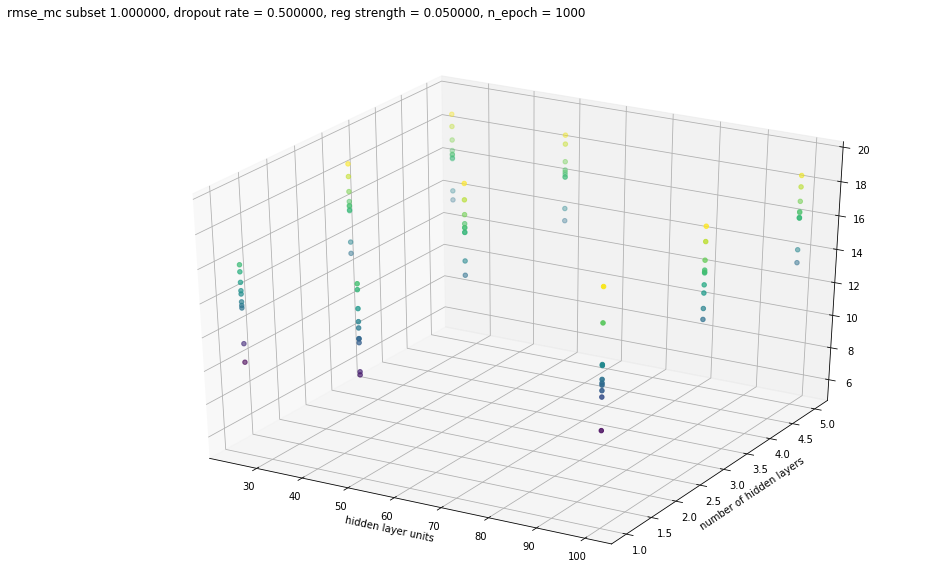

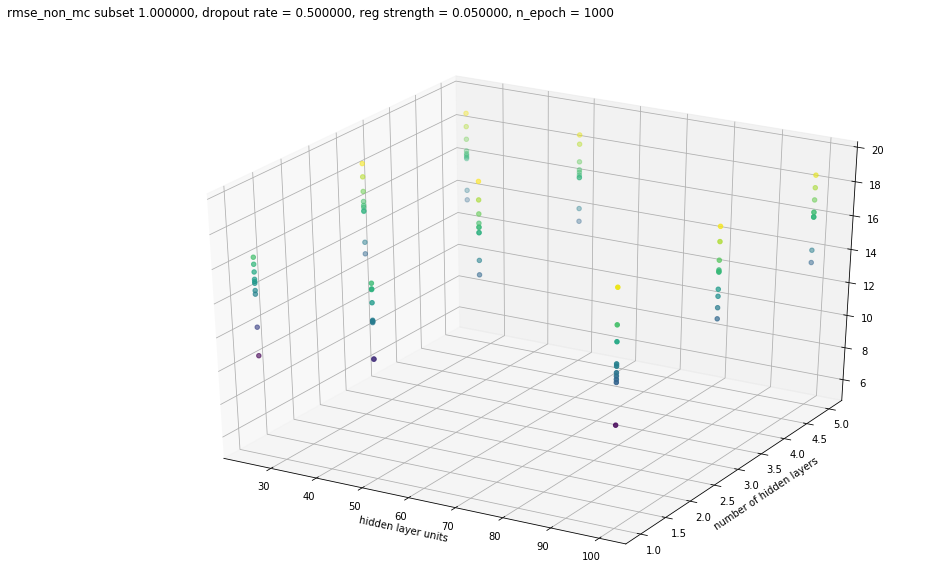

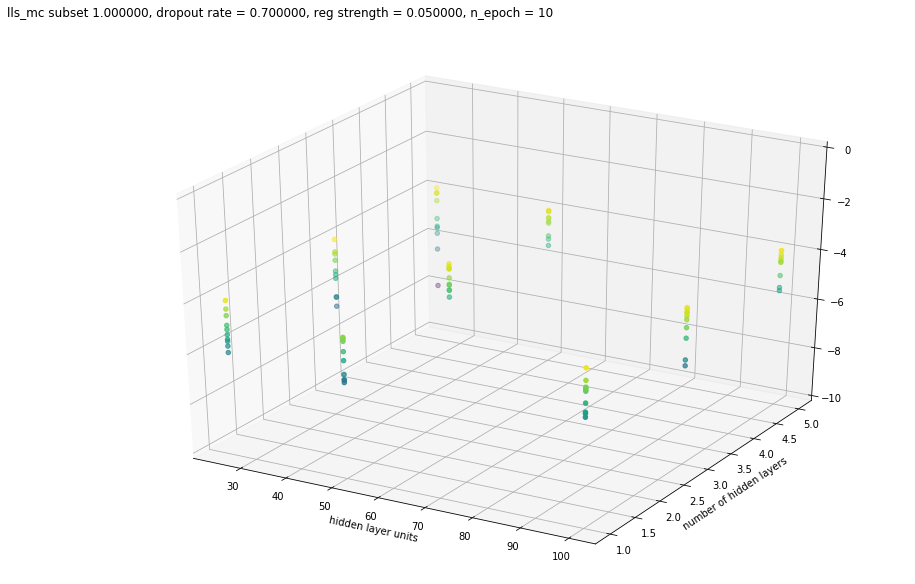

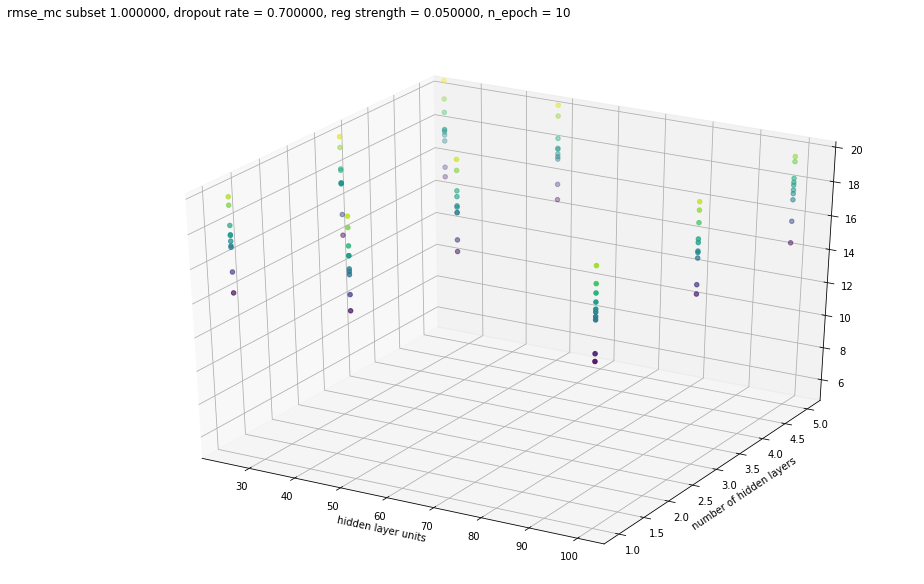

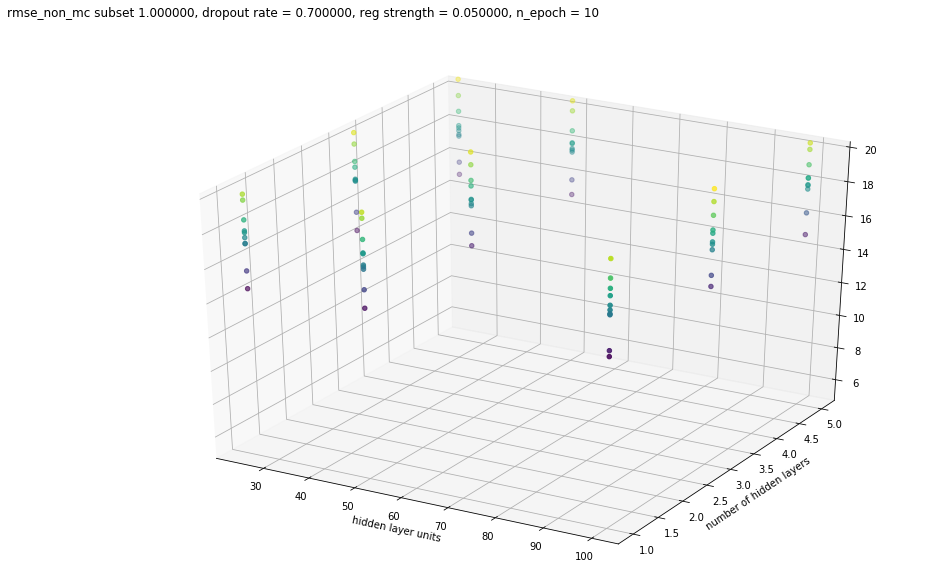

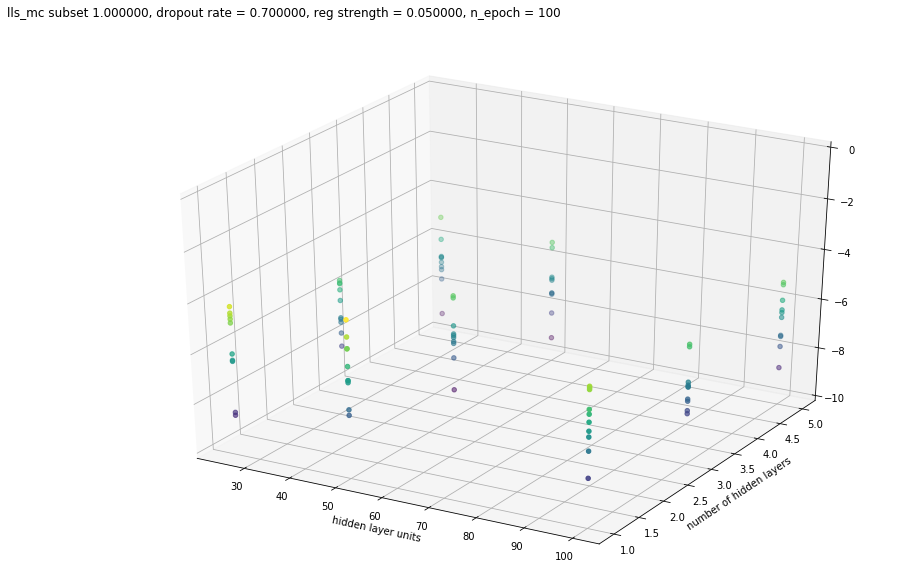

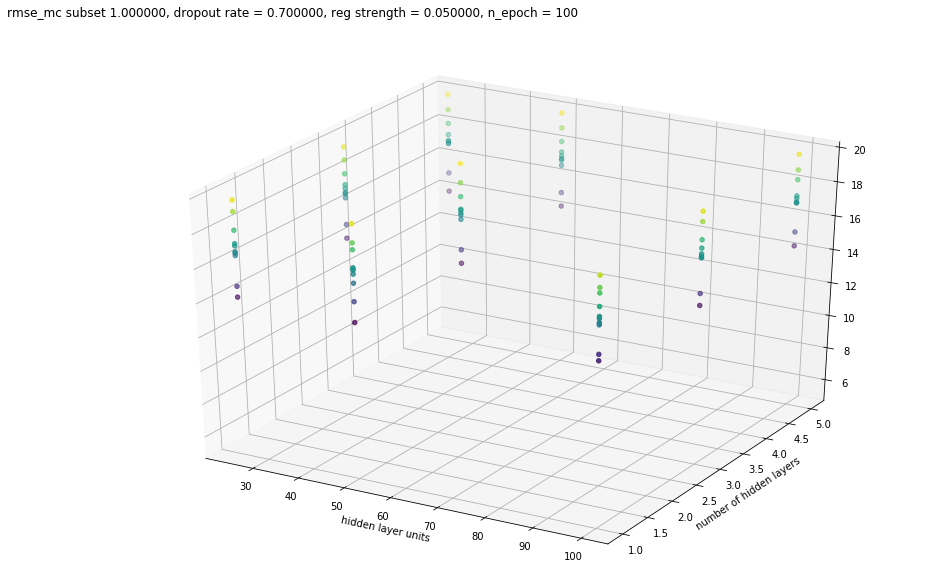

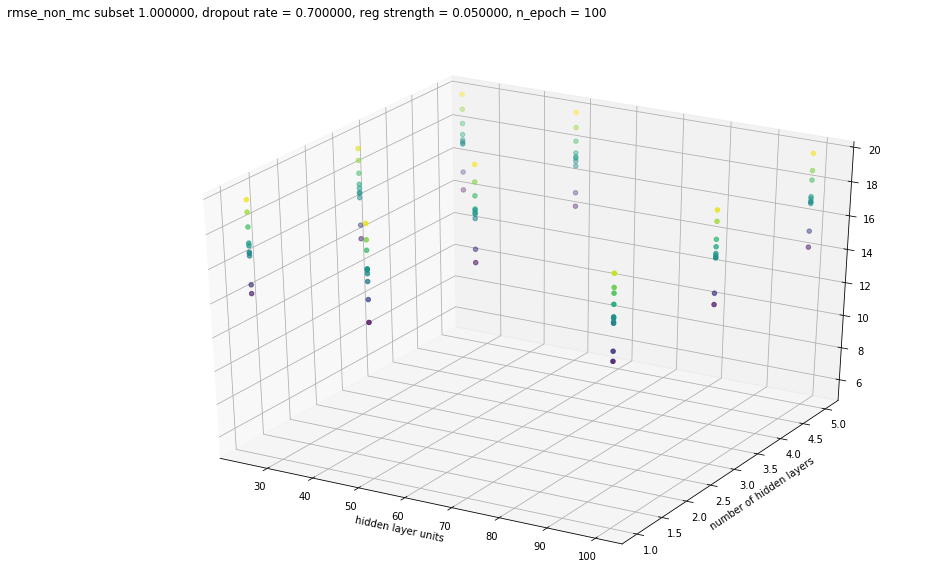

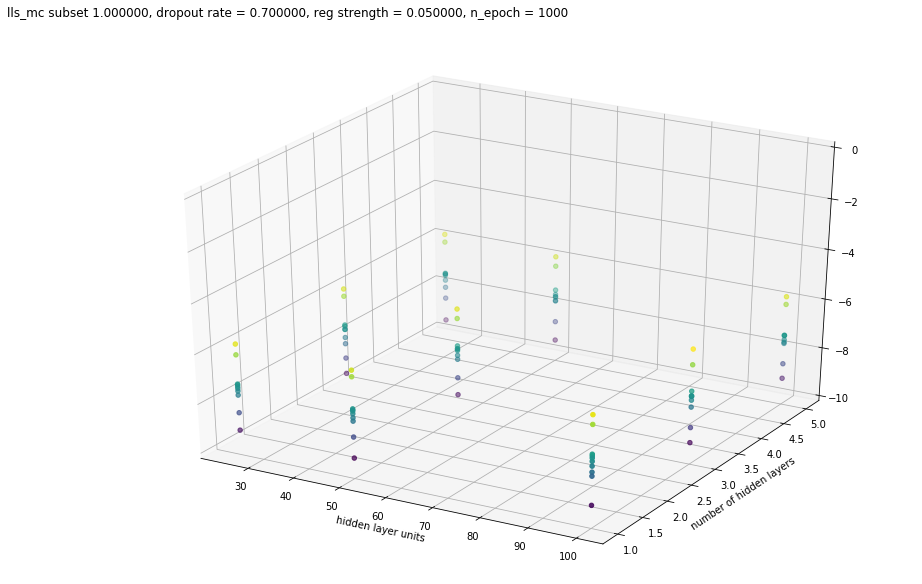

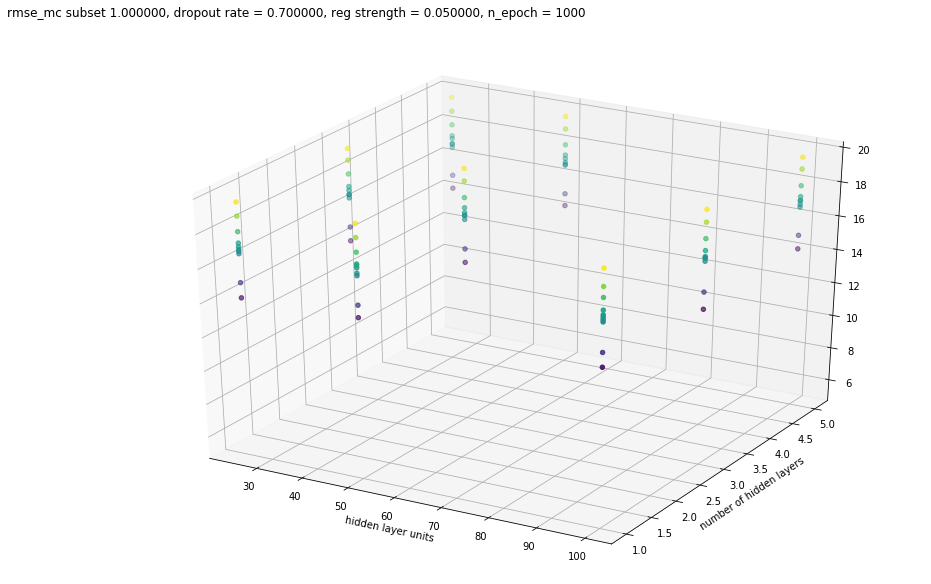

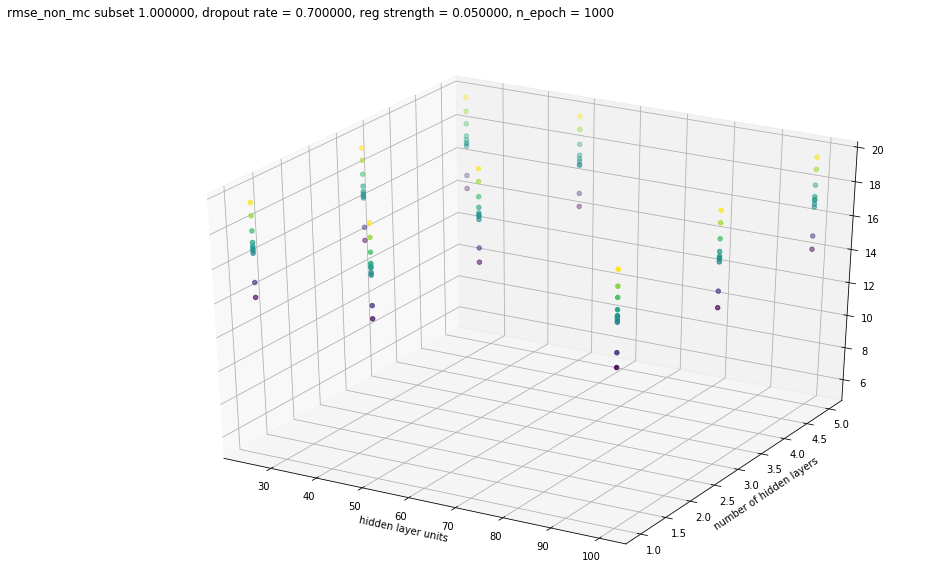

In [16]:
from mpl_toolkits.mplot3d import Axes3D

experiment_root_directory = os.path.join(
    './test_results',
    'error_convergence_1',
    uci_dataset_name,
    test_start_time,
)

for subset_prop, dropout_rate, reg_strength, n_epoch in itertools.product(
    subset_proportions, dropout_rates, reg_strengths, n_epochs
):
    for metric_name in ['lls_mc', 'rmse_mc', 'rmse_non_mc']:
        figure_file_name = (
            '3d_' + str(subset_prop)
            + '_' + str(dropout_rate)
            + '_' + str(reg_strength)
            + '_' + str(n_epoch)
            + '_' + metric_name + '.png'
        )
        
        figure_title = (
            metric_name 
            + (' subset %f, dropout rate = %f, reg strength = %f, n_epoch = %d' % (subset_prop, dropout_rate, reg_strength, n_epoch))
        )

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        fig.tight_layout(pad=2, rect=[0, 0.00, 2, 2])
        
        hidden_dims_data = []
        hidden_layers_data = []
        scores_data = []
        
        for hidden_dim in network_hidden_dims:
            for n_layer in network_hidden_layers:
                # Open the score file
                score_file_path = os.path.join(
                    experiment_root_directory,
                    (
                        str(subset_prop) 
                        + '_' + str(hidden_dim)
                        + '_' + str(n_layer) 
                        + '_' + str(dropout_rate) 
                        + '_' + str(reg_strength)
                        + '_' + str(n_epoch)
                    ),
                    metric_name + '.txt',
                )

                scores = np.loadtxt(score_file_path).T
                
                for s in scores[1]:
                    # Multiple values (for each split) for
                    # each (hidden_dim, n_layer) combination
                    hidden_dims_data.append(hidden_dim)
                    hidden_layers_data.append(n_layer)
                    scores_data.append(s)
                    
                mean = np.mean(scores[1])
                var = np.var(scores[1])

        ax.set_xlabel('hidden layer units')
        ax.set_ylabel('number of hidden layers')
        
        if metric_name in ('rmse_mc', 'rmse_non_mc'):
            ax.set_zlim([5, 20])
        elif metric_name == 'lls_mc':
            ax.set_zlim([-10, 0])
    
        ax.scatter3D(hidden_dims_data, hidden_layers_data, scores_data, c=scores_data)

        fig.suptitle(figure_title, y=2.05)        
        
        plt.savefig(
            os.path.join(experiment_root_directory, figure_file_name),
            dpi=600,
            bbox_inches='tight',
        )
        
        plt.show()